In [32]:
import json, re, os, sys
from dataclasses import dataclass
from typing import Literal
from openai import OpenAI
from dotenv import load_dotenv

In [33]:
load_dotenv()  # load variables from .env
API_KEY = os.getenv("OPENAI_API_KEY")
if not API_KEY:
    raise ValueError("Missing OPENAI_API_KEY environment variable")

client = OpenAI(api_key=API_KEY)

In [14]:
# --- Multi-check user story grader (boolean tags) with early-exit + progress ---
import os, time, random, re, json
from typing import Dict, Any, List, Tuple, Union
from dataclasses import dataclass
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm  # pip install tqdm

# ====================== CONFIG ======================
MODEL = "gpt-4o"
TEMPERATURE = 0.0

# Allow small JSON outputs
JSON_MAX_TOKENS = 120

RETRIES = 5
BASE_DELAY = 2.0  # Increased base delay
GLOBAL_CALL_DELAY = 1.0  # Much longer delay between requests

# Paste your ALREADY_DONE exactly as you have it:
ALREADY_DONE = """
The app ALREADY implements these 5 user stories. Any new story that duplicates or trivially rephrases one of these should be considered a duplicate (grade low and say it is already implemented).

1) Sign-in / Login
   As a user, I want to sign up and log into the app, so that my ToDos are kept across devices.

2) Create / Add a ToDo
   As a user, I want to create a new ToDo, so that I can add new tasks to my list.

3) List of ToDos
   As a user, I want to view a list of my ToDos, so that I can easily see all my pending tasks at once.

4) Edit a ToDo
   As a user, I want to edit and view details of my ToDos, so that I can update tasks or review their detailed descriptions.

5) Location-based ToDos
   As a user, I want to add locations to my ToDos and see them on a map, so that I can plan my work based on where tasks are.
"""

# Enable/disable specific checks if needed
ENABLED_CHECKS = {
    "duplicate": True,
    "irrelevant": True,
    "vague": True,
    "oversized": True,
    "role-mismatch": True,
    "ui-polish": True,
    "typo": True,
    "bad-structure": True,   # NEW CRITERION
}

# Checks are prioritized so we can early-exit on duplicate/irrelevant
PRIORITY_CHECKS = ["duplicate", "irrelevant"]
OTHER_CHECKS_ORDER = ["typo", "oversized", "role-mismatch", "ui-polish", "bad-structure", "vague"]

# ================== PROMPT FRAMING (updated) ==================
SYSTEM_HEADER = (
    "You are acting as a teacher grading a user story for a ToDo app.\n"
    "The app ALREADY IMPLEMENTS the following 5 user stories. If a student repeats any of these or trivially rephrases them, that is a DUPLICATE:\n\n"
    + ALREADY_DONE +
    "\nYou will be given a single criterion to check.\n"
    "Return ONLY the word true or false (lowercase), with no punctuation or explanation."
)

# ================== CHECK DEFINITIONS (your wording preserved) ==================
CHECK_DEFS: Dict[str, str] = {
    "duplicate": (
        "DUPLICATE: Return true ONLY if the user story is the SAME AS or a TRIVIAL REPHRASING of one of the 5 ALREADY IMPLEMENTED stories listed in the system prompt. "
        "Count as duplicate if the story asks for any of these same outcomes even with different wording."
        "Do NOT mark as duplicate features like reminders/notifications, tags/categories, priorities, search/filter/sort, recurring tasks, subtasks/checklists, "
        "attachments, archive, snooze, collaboration/sharing, timers/time-tracking, UI themes/dark mode, onboarding, or similar new capabilities.\n"
        "Minor typos or synonyms do not change the essence. If uncertain, return false."
    ),
    "irrelevant": (
        "IRRELEVANT: Return true ONLY if the story is completely outside the scope of a ToDo/task management application "
        "(e.g., booking flights, ordering food, running a business). "
        "Return false if the story is related to tasks/ToDos OR the application’s user experience (UI, themes, dark mode, accessibility, navigation). "
    ),
    "vague": (
        "VAGUE: Return true ONLY if the story is missing essential details in role, action, or benefit "
        "(e.g., 'As a user, I want to do things so that stuff works'). "
        "Return false if the story gives a clear action and benefit, even if subjective (e.g., dark mode for eye comfort). "
        "UI or polish-related stories with a stated benefit are NEVER vague."
    ),
    "oversized": (
        "OVERSIZED: Return true ONLY if the story requests multiple distinct, unrelated features.\n"
        "Consider these as SINGLE features (return false):\n"
        "- Related actions for one goal: 'create groups and assign tasks' (team management)\n"
        "- Sequential steps: 'add task and set reminder' (task creation workflow)\n"
        "- Feature with configuration: 'dark mode and custom colors' (theming)\n"
        "- Natural complements: 'search and filter tasks' (finding tasks)\n"
        "Return true ONLY for clearly separate features:\n"
        "- 'add tasks and book flights' (unrelated domains)\n"
        "- 'create todos and play music and send emails' (multiple distinct features)\n"
        "If actions work together toward one user goal, it's one feature."
    ),
    "role-mismatch": (
    "ROLE-MISMATCH: Return true ONLY if the role is completely inappropriate for a ToDo app user.\n"
    "Accept these types of roles:\n"
    "- Individual users: user, student, grandpa, parent, teacher, employee, etc.\n"
    "- Organizational roles: manager, team leader, supervisor, coordinator, etc.\n"
    "- Users with characteristics: busy user, old user, blind user, etc.\n"
    "Return true ONLY for roles that make no sense in a ToDo context:\n"
    "- Non-human: dog, cat, robot, AI, system\n"
    "- Completely unrelated: customer buying groceries, patient in hospital\n"
    "If no role is present, return false (bad-structure handles missing roles)."
),
    "ui-polish": (
        "UI-POLISH: Return true if the story is mainly a UI/visual tweak or comfort feature without adding core ToDo functionality "
        "(e.g., themes, animations, onboarding tour, dark mode). Return false otherwise."
    ),
    "typo": (
        "TYPO: Return true if the user story contains obvious spelling/grammar typos (e.g., misspelled words, malformed sentences). "
        "Return false if the text is clean."
    ),
    "bad-structure": (
    "BAD-STRUCTURE: Follow these exact steps:\n"
    "Step 1: Look for 'as a' or 'as an' anywhere in the text (case insensitive)\n"
    "Step 2: Look for 'i want' anywhere in the text (case insensitive)\n"
    "Step 3: Look for 'so that' anywhere in the text (case insensitive)\n"
    "If ALL THREE are found, return false. If ANY is missing, return true.\n"
    "Example: 'as a user, i want to delete a todo so that i can manage' - all three found = FALSE"
)
}

# ================== JSON CALL ==================
def _extract_json_obj(text: str) -> dict:
    text = (text or "").strip()
    try:
        obj = json.loads(text)
        if isinstance(obj, dict):
            return obj
    except Exception:
        pass
    m = re.search(r"\{.*\}", text, flags=re.DOTALL)
    if not m:
        raise ValueError(f"Expected JSON object, got: {text!r}")
    return json.loads(m.group(0))

def _ask_all_checks(story: str, enabled_keys: List[str]) -> Dict[str, bool]:
    criteria_lines = [f"{key}: {CHECK_DEFS[key]}" for key in enabled_keys]
    example_pairs = ", ".join([f"\"{k}\": false" for k in enabled_keys])

    schema_hint = (
        "Return ONLY a strict JSON object with each requested key set to true or false.\n"
        f"Example: {{{example_pairs}}}\n"
        "No prose, no comments, no trailing text."
    )

    user_msg = (
        "Criterion bundle (evaluate ALL independently and set booleans):\n"
        + "\n\n".join(criteria_lines)
        + f"\n\nUser story:\n\"\"\"\n{story}\n\"\"\"\n\n{schema_hint}"
    )

    last_err = None
    for attempt in range(1, RETRIES + 1):
        try:
            time.sleep(GLOBAL_CALL_DELAY)
            resp = client.chat.completions.create(
                model=MODEL,
                temperature=TEMPERATURE,
                max_tokens=JSON_MAX_TOKENS,
                messages=[
                    {"role": "system", "content": SYSTEM_HEADER},
                    {"role": "user", "content": user_msg},
                ],
            )
            raw = resp.choices[0].message.content
            obj = _extract_json_obj(raw)

            out: Dict[str, bool] = {}
            for k in enabled_keys:
                v = obj.get(k, False)
                out[k] = bool(v) if isinstance(v, (bool, int)) else str(v).strip().lower() == "true"
            return out
        except Exception as e:
            last_err = e
            # Check if it's a rate limit error and wait longer
            if "rate_limit_exceeded" in str(e) or "429" in str(e):
                sleep_s = 1 + random.uniform(0, 2)  # Wait 60-90 seconds for rate limits
                print(f"Rate limit hit, waiting {sleep_s:.1f}s...")
            else:
                sleep_s = BASE_DELAY * (2 ** (attempt - 1)) + random.uniform(0, 0.3)
            time.sleep(sleep_s)
    raise RuntimeError(f"JSON check failed after {RETRIES} attempts: {last_err}")

# ================== STORY CHECK ==================
@dataclass
class StoryChecks:
    story: str
    booleans: Dict[str, bool]
    tags: List[str]

def run_checks_for_story(story: str, enabled: Dict[str, bool] = ENABLED_CHECKS) -> StoryChecks:
    enabled_keys = [k for k, on in enabled.items() if on]
    bools = _ask_all_checks(story, enabled_keys)

    # Early exit
    # early = []
    # if bools.get("duplicate", False):
    #     early.append("duplicate")
    # if bools.get("irrelevant", False):
    #     early.append("irrelevant")
    # if early:
    #     for k in bools.keys():
    #         if k not in ("duplicate", "irrelevant", "bad-structure"):
    #             bools[k] = False
    #     return StoryChecks(story, bools, early)

    tags = [k for k, v in bools.items() if v]
    return StoryChecks(story, bools, tags)

# ================== BATCH RUN ==================
def run_checks_batch(stories: List[str], concurrency: int = 6) -> List[StoryChecks]:
    results: List[Union[StoryChecks, None]] = [None] * len(stories)

    def _worker(i: int, s: str):
        return i, run_checks_for_story(s)

    with ThreadPoolExecutor(max_workers=concurrency) as ex, \
         tqdm(total=len(stories), desc="Checking stories", unit="story") as pbar:
        futures = [ex.submit(_worker, i, s) for i, s in enumerate(stories)]
        for fut in as_completed(futures):
            i, sc = fut.result()
            results[i] = sc
            pbar.update(1)

    return results  # type: ignore

# ================== EXAMPLES ==================
EXAMPLES = [
"as a user, i want to be able to delete a todo so that i can manage my tasks better",
"as a user, i want to be able to delete a todo so that i can manage my tasks better",
"as a user, i want to be able to delete a todo so that i can manage my tasks better",
"as a user, i want to be able to delete a todo",
"as a user, i want to be able to delete a todo so that i can manage my tasks better",
"i want to be able to delete a todo so that i can manage my tasks better",
"as a user, i want to be able to delete a todo so that i can manage my tasks better",
"as a user, i want to be able to delete a todo so that i can manage my tasks better",
"as a user, i want to be able to delete a todo so that i can manage my tasks better",
"as a user, i want to be able to delete a todo",
"as a user, i want to be able to delete a todo so that i can manage my tasks better",
"i want to be able to delete a todo so that i can manage my tasks better",

]

if __name__ == "__main__":
    out = run_checks_batch(EXAMPLES, concurrency=4)
    for r in out:
        print("\nStory:", r.story)
        print("Tags :", r.tags)
        print("Flags:", {k: int(v) for k, v in r.booleans.items()})

Checking stories:   0%|          | 0/12 [00:00<?, ?story/s]

Checking stories: 100%|██████████| 12/12 [00:06<00:00,  1.75story/s]


Story: as a user, i want to be able to delete a todo so that i can manage my tasks better
Tags : []
Flags: {'duplicate': 0, 'irrelevant': 0, 'vague': 0, 'oversized': 0, 'role-mismatch': 0, 'ui-polish': 0, 'typo': 0, 'bad-structure': 0}

Story: as a user, i want to be able to delete a todo so that i can manage my tasks better
Tags : []
Flags: {'duplicate': 0, 'irrelevant': 0, 'vague': 0, 'oversized': 0, 'role-mismatch': 0, 'ui-polish': 0, 'typo': 0, 'bad-structure': 0}

Story: as a user, i want to be able to delete a todo so that i can manage my tasks better
Tags : []
Flags: {'duplicate': 0, 'irrelevant': 0, 'vague': 0, 'oversized': 0, 'role-mismatch': 0, 'ui-polish': 0, 'typo': 0, 'bad-structure': 0}

Story: as a user, i want to be able to delete a todo
Tags : ['bad-structure']
Flags: {'duplicate': 0, 'irrelevant': 0, 'vague': 0, 'oversized': 0, 'role-mismatch': 0, 'ui-polish': 0, 'typo': 0, 'bad-structure': 1}

Story: as a user, i want to be able to delete a todo so that i can manage

In [16]:
# ==================== 100 Mixed User Stories Test Suite =====================
from collections import Counter, defaultdict
from tqdm import tqdm

def _t(story, *tags):
    # tags must match your checker names: duplicate, irrelevant, vague, oversized, role-mismatch, ui-polish, typo
    # if no flaw is expected, pass None
    clean_tags = [t for t in tags if t is not None]
    return {"story": story, "expected": clean_tags}

TESTS = []

# ---- [duplicate] ----
TESTS += [
    _t("As a user, I want to log in with Google so that my ToDos sync across devices.", "duplicate"),
    _t("As a user, I want to sign up and log in so that my tasks persist between sessions.", "duplicate"),
    _t("As a user, I want to create a ToDo with title and due date so that I can track work.", "duplicate"),
    _t("As a user, I want to add a new task with description and assignee so that I can assign work.", "duplicate"),
    _t("As a user, I want to view a list of my ToDos so that I can see pending tasks.", "duplicate"),
    _t("As a user, I want the list of ToDos to update automatically after edits.", "duplicate"),
    _t("As a user, I want to edit a ToDo’s details so that I can correct info.", "duplicate"),
    _t("As a user, I want to delete a ToDo from its detail screen.", "duplicate"),
    _t("As a user, I want to mark a ToDo as completed so that I can track progress.", "duplicate"),
    _t("As a user, I want to set a location on a ToDo so that I can see it on a map.", "duplicate"),
    _t("As a user, I want to view my ToDos on a map with pins.", "duplicate"),
    _t("As a user, I want to reverse-geocode locations for my ToDos.", "duplicate"),
    _t("As a user, I want the map view to use Google Maps so that I can see my ToDos.", "duplicate"),
    _t("As a user, I want to go back from the ToDo editor to the list after saving.", "duplicate"),
    _t("As a user, I want to create a new task so that I can track my work.", "duplicate"),
    _t("As a user, I want to set a due date so that I finish tasks on time.", "duplicate"),
    _t("As a user, I want to mark tasks as complete so that I see my progress.", "duplicate"),
    _t("As a user, I want to add a description to a task so that I remember details.", "duplicate"),
    _t("As a user, I want to assign a task to someone so that responsibilities are clear.", "duplicate"),
    _t("As a user, I want to delete tasks so that I remove things I no longer need.", "duplicate"),
    _t("As a user, I want to view my tasks in a list so that I know what I need to do.", "duplicate"),
    _t("As a user, I want to edit a task so that I can update its details.", "duplicate"),
    _t("As a user, I want to see my ToDos on a map so that I can plan by location.", "duplicate"),
]

# # ---- [irrelevant] ----
# TESTS += [
#     _t("As a traveler, I want to book flights so that I can plan my trips.", "irrelevant"),
#     _t("As a gamer, I want to save high scores so that I can track my performance.", "irrelevant"),
#     _t("As a shopper, I want to track discounts so that I buy at lower prices.", "irrelevant"),
#     _t("As a viewer, I want to stream movies so that I can watch new releases.", "irrelevant"),
#     _t("As a foodie, I want to order meals so that I can eat at home.", "irrelevant"),
#     _t("As a banker, I want to trade stocks so that I grow my portfolio.", "irrelevant"),
#     _t("As a student, I want to view exam results so that I know my grades.", "irrelevant"),
#     _t("As a driver, I want traffic alerts so that I avoid delays.", "irrelevant"),
#     _t("As a patient, I want to book doctor appointments so that I can see a specialist.", "irrelevant"),
#     _t("As a tourist, I want museum tickets so that I can enter quickly.", "irrelevant"),
#     _t("As a reader, I want book recommendations so that I can discover novels.", "irrelevant"),
#     _t("As a music fan, I want to create playlists so that I can listen to songs.", "irrelevant"),
#     _t("As a customer, I want product reviews so that I can choose better items.", "irrelevant"),
#     _t("As a sports fan, I want live match stats so that I can follow my team.", "irrelevant"),
# ]

# # ---- [ui-polish] ----
# TESTS += [
#     _t("As a user, I want dark mode so that my eyes don’t hurt at night.", "ui-polish"),
#     _t("As a user, I want custom themes so that the app matches my taste.", "ui-polish"),
#     _t("As a user, I want adjustable font size so that text is easier to read.", "ui-polish"),
#     _t("As a user, I want subtle animations so that the app feels smooth.", "ui-polish"),
#     _t("As a user, I want compact list density so that I see more tasks at once.", "ui-polish"),
#     _t("As a user, I want a minimalist mode so that the UI feels less cluttered.", "ui-polish"),
#     _t("As a user, I want a welcome tour so that I can learn the app quickly.", "ui-polish"),
#     _t("As a user, I want an icon badge with task counts so that I see pending work.", "ui-polish"),
#     _t("As a user, I want customizable swipe gestures so that I act quickly.", "ui-polish"),
#     _t("As a user, I want haptic feedback on actions so that interactions feel responsive.", "ui-polish"),
#     _t("As a user, I want high-contrast mode so that content is legible.", "ui-polish"),
#     _t("As a user, I want larger tap targets so that actions are easier on mobile.", "ui-polish"),
#     _t("As a user, I want a cleaner task card layout so that information is scannable.", "ui-polish"),
#     _t("As a user, I want color-blind friendly palettes so that I can distinguish states.", "ui-polish"),
# ]

# ---- [vague] ----
# TESTS += [
#     _t("As a user, I want improvements so that it is better.", "vague"),
#     _t("As a user, I want more options so that I have flexibility.", "vague"),
#     _t("As a user, I want enhancements so that I am productive.", "vague"),
#     _t("As a user, I want to do things so that it is useful.", "vague"),
#     _t("As a user, I want support so that I’m satisfied.", "vague"),
#     _t("As a user, I want efficiency so that I save time.", "vague"),
#     _t("As a user, I want features so that I can benefit.", "vague"),
#     _t("As a user, I want changes so that the app improves.", "vague"),
#     _t("As a user, I want it to be faster so that it’s good.", "vague"),
#     _t("As a user, I want everything so that life is easier.", "vague"),
#     _t("As a user, I want enhancements to tasks so that it helps.", "vague"),
# ]

# # ---- [oversized] ----
# TESTS += [
#     _t("As a user, I want to have reminders and recurring tasks so that I never forget things.", "oversized"),
#     _t("As a user, I want to add tags and priorities so that I can organize my tasks better.", "oversized"),
#     _t("As a user, I want subtasks and notifications so that I can break work into steps and track progress.", "oversized"),
#     _t("As a user, I want to filter tasks and share them with others so that collaboration is easier.", "oversized"),
#     _t("As a user, I want offline support and syncing across devices so that I always have my tasks.", "oversized"),
# ]

# # ---- [role-mismatch] ----
# TESTS += [
#     _t("As an admin, I want to delete any user’s tasks so that the system stays clean.", "role-mismatch"),
#     _t("As a moderator, I want to edit others’ tasks so that rules are enforced.", "role-mismatch"),
#     _t("As a superuser, I want to view all private tasks so that I can audit activity.", "role-mismatch"),
#     _t("As HR, I want to see employees’ personal tasks so that I can assess productivity.", "role-mismatch"),
#     _t("As a reviewer, I want to approve other users’ tasks so that quality is ensured.", "role-mismatch"),
#     _t("As an auditor, I want access to all task histories so that compliance is verified.", "role-mismatch"),
#     _t("As a manager, I want to reassign anyone’s tasks so that workload is controlled.", "role-mismatch"),
#     _t("As a super admin, I want to reset users’ accounts so that they start fresh.", "role-mismatch"),
# ]

# # ---- [typo] ----
# TESTS += [
#     _t("As a usr, I wnt dark mode so that my eys don’t hurt at nite.", "typo", "ui-polish"),
#     _t("As a user, I want recuring ToDos so that I dont need to re-enter taks.", "typo"),
#     _t("As a user, I want a srch bar so that I can find tasks fst.", "typo"),
#     _t("As a user, I want subtasks so that big tasx are split.", "typo"),
#     _t("As a user, I want filtres so that I can focs on what matters.", "typo"),
#     _t("As a user, I want setting a tag so that tasks are organzed.", "typo"),
#     _t("As a user, I want snooze tasks so that I can dely them.", "typo"),
#     _t("As a user, I want archive ToDos so that my list stays cleen.", "typo"),
#     _t("As a user, I want attach fils so that docs stay togther.", "typo"),
#     _t("As a user, I want overdue vew so that I can act quikly.", "typo"),
# ]

# # ---- [perfect] ----
# TESTS += [
#     _t("As a user, I want to tag my tasks so that I can organize them by topic.", None),
#     _t("As a user, I want to set priority on tasks so that I focus on the most important ones first.", None),
#     _t("As a user, I want recurring tasks so that I don’t have to re-create repeating work.", None),
#     _t("As a user, I want reminders for tasks so that I don’t miss deadlines.", None),
#     _t("As a user, I want to search tasks by keyword so that I can quickly find what I need.", None),
#     _t("As a user, I want to filter tasks by tag or assignee so that I can focus on a subset.", None),
#     _t("As a user, I want to sort tasks by due date or priority so that I see what matters first.", None),
#     _t("As a user, I want to add subtasks to a task so that I can break work into steps.", None),
#     _t("As a user, I want to attach files to a task so that related documents stay together.", None),
#     _t("As a user, I want an Overdue view so that I can quickly act on late tasks.", None),
# ]

# --------------------- Run and Compare ---------------------
stories = [t["story"] for t in TESTS]

# run model in batches
all_results = []
for i in range(0, len(stories), 20):
    batch = stories[i:i+20]
    batch_results = run_checks_batch(batch, concurrency=5)
    all_results.extend(batch_results)

pred = all_results  # <--- FIX: now pred is defined

# Convert predictions to sets; apply early-exit expectation for duplicate/irrelevant
pred_sets = []
for r in pred:
    pred_sets.append(set(r.tags))

exp_sets = []
for t in TESTS:
    exp = set(t["expected"])
    # If expected contains duplicate or irrelevant, assume ONLY that tag (early-exit semantics)
    if "duplicate" in exp:
        exp = {"duplicate"}
    elif "irrelevant" in exp:
        exp = {"irrelevant"}
    exp_sets.append(exp)

# Overall exact set-match accuracy
matches = [int(p == e) for p, e in zip(pred_sets, exp_sets)]
overall_acc = sum(matches) / len(matches)

# Per-tag precision/recall
all_tags = ["duplicate","irrelevant","ui-polish","vague","oversized","role-mismatch","typo"]
per_tag = {}
for tag in all_tags:
    tp = sum(1 for p,e in zip(pred_sets, exp_sets) if (tag in p and tag in e))
    fp = sum(1 for p,e in zip(pred_sets, exp_sets) if (tag in p and tag not in e))
    fn = sum(1 for p,e in zip(pred_sets, exp_sets) if (tag not in p and tag in e))
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    rec  = tp / (tp + fn) if (tp + fn) else 0.0
    per_tag[tag] = (prec, rec, tp, fp, fn)

print(f"\nAccuracy (exact tag-set match): {overall_acc*100:.1f}%  ({sum(matches)}/{len(matches)})")

print("\nPer-tag precision / recall:")
for tag in all_tags:
    prec, rec, tp, fp, fn = per_tag[tag]
    print(f"  {tag:<14} P={prec*100:5.1f}%  R={rec*100:5.1f}%   TP={tp:3}  FP={fp:3}  FN={fn:3}")

print("\nSample mismatches:")
shown = 0
for (t, pset, eset) in zip(TESTS, pred_sets, exp_sets):
    # if pset != eset:
        print(f"- Story: {t['story']}\n  expected={sorted(list(eset))}\n  predicted={sorted(list(pset))}\n")
        shown += 1
        # if shown >= 12:
        #     break

Checking stories: 100%|██████████| 3/3 [00:03<00:00,  1.05s/story]


Accuracy (exact tag-set match): 60.9%  (14/23)

Per-tag precision / recall:
  duplicate      P=100.0%  R= 60.9%   TP= 14  FP=  0  FN=  9
  irrelevant     P=  0.0%  R=  0.0%   TP=  0  FP=  0  FN=  0
  ui-polish      P=  0.0%  R=  0.0%   TP=  0  FP=  1  FN=  0
  vague          P=  0.0%  R=  0.0%   TP=  0  FP=  0  FN=  0
  oversized      P=  0.0%  R=  0.0%   TP=  0  FP=  0  FN=  0
  role-mismatch  P=  0.0%  R=  0.0%   TP=  0  FP=  0  FN=  0
  typo           P=  0.0%  R=  0.0%   TP=  0  FP=  0  FN=  0

Sample mismatches:
- Story: As a user, I want to log in with Google so that my ToDos sync across devices.
  expected=['duplicate']
  predicted=['duplicate']

- Story: As a user, I want to sign up and log in so that my tasks persist between sessions.
  expected=['duplicate']
  predicted=['duplicate']

- Story: As a user, I want to create a ToDo with title and due date so that I can track work.
  expected=['duplicate']
  predicted=['duplicate']

- Story: As a user, I want to add a new task wi

In [29]:
from openai import OpenAI
from tqdm import tqdm


# ----------------- Tag penalties -----------------
TAG_PENALTIES = {
    "duplicate": -5,
    "irrelevant": -5,
    "vague": -2,
    "oversized": -2,
    "role-mismatch": -3,
    "ui-polish": -2,
    "typo": -1,
    "bad-structure": -3,
}

# ----------------- Grade computation -----------------
def compute_grade(tags):
    score = 5
    for t in tags:
        score += TAG_PENALTIES.get(t, 0)
    return max(score, 0)

# ----------------- Feedback generation -----------------
def generate_feedback(story, tags, grade):
    if not tags:
        prompt = f"""
Story: "{story}"
Grade: {grade}/5 (no issues found)

Write brief feedback (max 25 words) praising the story's clarity, relevance, and appropriate scope for the ToDo app.
Return only the feedback.
        """
    else:
        # Sort tags by priority: duplicate/irrelevant first, then others
        priority_tags = ["duplicate", "irrelevant"]
        sorted_tags = [t for t in priority_tags if t in tags] + [t for t in tags if t not in priority_tags]
        
        # Create penalty information for each tag
        tag_penalties = [f"{tag} ({TAG_PENALTIES[tag]})" for tag in sorted_tags]
        penalties_text = ", ".join(tag_penalties)
        
        prompt = f"""
You are grading a user story for a mobile ToDo app that supports login, creating tasks, listing tasks, editing tasks, and viewing them on a map.

Story: "{story}"
Tags: {sorted_tags}
Grade: {grade}/5

Write feedback that addresses ONLY the specific tags provided: {sorted_tags}
Include the point penalty in parentheses after mentioning each issue.
Use student-friendly language, not technical tag names.

Tag penalties: {penalties_text}

Guidelines for each tag (use natural language, not tag names):
- If duplicate: note it repeats an existing feature (-5)
- If irrelevant: say it is outside the app's scope (-5)
- If vague: request clearer, task-related actions/outcomes (-2)
- If oversized: say it combines too many features at once (-2)
- If role-mismatch: say the role is not appropriate for the app (-3)
- If ui-polish: describe as "cosmetic feature, not essential functionality" (-2)
- If typo: mention spelling/grammar errors reduce clarity (-1)
- If bad-structure: note it doesn't follow proper user story format (-3)

Be concise (max 35 words). Use natural descriptions, not tag names.
Return only the feedback.
        """
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2,
    )
    return response.choices[0].message.content.strip()

# ----------------- Example usage -----------------
if __name__ == "__main__":
    # Example user stories
    stories = [
        "As a user, I want to create a new task so that I can track my work.", # duplicate
        "As a gamer, I want to save high scores so that I can track my performance.", # irrelevant
        "As a user, I want improvements so that it is better.", # vague
        "As a usr, I wnt dark mode so that my eys don’t hurt at nite." # typo + ui-polish
    ]

    # Replace this with your real checker:
    fake_checker_outputs = [
        ["duplicate"],
        ["irrelevant"],
        ["vague"],
        ["typo", "ui-polish"],
    ]

    results = []
    for story, tags in tqdm(zip(stories, fake_checker_outputs), total=len(stories), desc="Grading stories"):
        grade = compute_grade(tags)
        feedback = generate_feedback(story, tags, grade)
        results.append((story, tags, grade, feedback))

    # Print results
    for story, tags, grade, feedback in results:
        print(f"\nStory: {story}")
        print(f"Tags: {tags}")
        print(f"Grade: {grade}/5")
        print(f"Feedback: {feedback}")

Grading stories: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Story: As a user, I want to create a new task so that I can track my work.
Tags: ['duplicate']
Grade: 0/5
Feedback: This user story repeats an existing feature of creating tasks, which is already covered in the app's functionality. Please provide a unique story to avoid duplication. (-5)

Story: As a gamer, I want to save high scores so that I can track my performance.
Tags: ['irrelevant']
Grade: 0/5
Feedback: This story is outside the app's scope, as it focuses on saving high scores for gaming rather than managing tasks. Please align your user story with the app's intended features. (-5)

Story: As a user, I want improvements so that it is better.
Tags: ['vague']
Grade: 3/5
Feedback: Your story is too vague. Please specify the improvements you want and how they will enhance the app's functionality. This will help clarify your goals and make the story more actionable. (-2)

Story: As a usr, I wnt dark mode so that my eys don’t hurt at nite.
Tags: ['typo', 'ui-polish']
Grade: 2/5
Feedb

In [34]:
# ----------------- Read user stories from txt file -----------------
def read_user_stories(txt_file="userStories.txt"):
    """
    Read user stories from userStories.txt file.
    Takes first 2 lines as the user stories and cleans them.
    """
    try:
        with open(txt_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        # Clean up lines (remove newlines, whitespace, and line numbers)
        stories = []
        for line in lines:
            line = line.strip()
            if line:
                # Remove leading numbers and whitespace (e.g., "1   " or "2.")
                import re
                cleaned_line = re.sub(r'^\d+\s*\.?\s*', '', line)
                stories.append(cleaned_line)
        
        # Always take first 2 lines only
        stories = stories[:2]
        
        if len(stories) < 2:
            print(f"Warning: Found only {len(stories)} user stories, expected 2")
            # Pad with empty stories if needed
            while len(stories) < 2:
                stories.append("")
        
        return stories
        
    except FileNotFoundError:
        print(f"Error: File '{txt_file}' not found!")
        sys.exit(1)
    except Exception as e:
        print(f"Error reading file: {e}")
        sys.exit(1)

# ----------------- Grade single student -----------------
def grade_single_student(output_file="graded_user_stories.json"):
    """
    Grade a single student's user stories from userStories.txt and save to JSON
    """
    # Initialize OpenAI client
    global client
    client = OpenAI()  # Make sure OPENAI_API_KEY environment variable is set
    
    txt_file = "userStories.txt"
    
    print(f"Reading user stories from '{txt_file}'...")
    stories = read_user_stories(txt_file)
    
    print(f"Processing first 2 user stories")
    
    results = []
    
    for i, story in enumerate(tqdm(stories, desc="Grading stories"), 1):
        if not story:
            print(f"Warning: Story {i} is empty, creating placeholder...")
            story_result = {
                "userStory": "",
                "tags": [],
                "grade": 0,
                "feedback": "No user story provided"
            }
            results.append(story_result)
            continue
            
        print(f"\nProcessing story {i}: {story[:50]}...")
        
        story_checks = run_checks_for_story(story)
        tags = story_checks.tags
        
        grade = compute_grade(tags)
        feedback = generate_feedback(story, tags, grade)
        
        story_result = {
            "userStory": story,
            "tags": tags,
            "grade": grade,
            "feedback": feedback
        }
        
        results.append(story_result)
        
        print(f"  Tags: {tags}")
        print(f"  Grade: {grade}/5")
        print(f"  Feedback: {feedback[:60]}...")
    
    # Save results to JSON
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)
        
        print(f"\nResults saved to '{output_file}'")
        print(f"Graded {len(results)} user stories")
        
        return results
        
    except Exception as e:
        print(f"Error saving results: {e}")
        sys.exit(1)

# ----------------- Main execution -----------------
if __name__ == "__main__":
    # Filter out Jupyter kernel arguments that start with --
    valid_args = [arg for arg in sys.argv[1:] if not arg.startswith('--')]
    
    # Check for optional output file argument
    if len(valid_args) > 0:
        output_file = valid_args[0]
    else:
        output_file = "graded_user_stories_indiv.json"
    
    txt_file = "userStories.txt"
    
    print("Single Student User Story Grader")
    print("=" * 40)
    print(f"Input file: {txt_file}")
    print(f"Output file: {output_file}")
    print()
    
    # Check if input file exists and has content
    if not os.path.exists(txt_file):
        print(f"Creating example input file '{txt_file}'...")
        example_content = """As a student, I want to see how long a study room is available so that I can choose one and study accordingly.
As a user, I want to filter products in a price range, so that I can find one within my budget."""
        
        with open(txt_file, 'w', encoding='utf-8') as f:
            f.write(example_content)
        
        print(f"Created '{txt_file}' with example user stories.")
        print("Please edit the file with your actual user stories and run again.")
        sys.exit(0)
    
    # Check if file has content
    with open(txt_file, 'r', encoding='utf-8') as f:
        content = f.read().strip()
    
    if not content:
        print(f"Warning: '{txt_file}' is empty!")
        print("Please add your user stories to the file (one per line) and run again.")
        print("Expected format:")
        print("Line 1: First user story")
        print("Line 2: Second user story")
        sys.exit(1)
    
    # Grade the stories
    results = grade_single_student(output_file)
    
    print("\nGrading Summary:")
    print("-" * 20)
    for i, result in enumerate(results, 1):
        print(f"Story {i}: Grade {result['grade']}/5, Tags: {result['tags']}")

Single Student User Story Grader
Input file: userStories.txt
Output file: graded_user_stories_indiv.json

Reading user stories from 'userStories.txt'...
Processing first 2 user stories


Grading stories:   0%|          | 0/2 [00:00<?, ?it/s]


Processing story 1: As a student, I want to see how long a study room ...


Grading stories:  50%|█████     | 1/2 [00:02<00:02,  2.78s/it]

  Tags: ['irrelevant']
  Grade: 0/5
  Feedback: This story is outside the app's scope, as it focuses on stud...

Processing story 2: As a user, I want to filter products in a price ra...


Grading stories: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]

  Tags: ['irrelevant']
  Grade: 0/5
  Feedback: This story is outside the app's scope, as it focuses on filt...

Results saved to 'graded_user_stories_indiv.json'
Graded 2 user stories

Grading Summary:
--------------------
Story 1: Grade 0/5, Tags: ['irrelevant']
Story 2: Grade 0/5, Tags: ['irrelevant']


In [36]:
# IMPROVED VERSION WITH BETTER RATE LIMITING
def grade_user_stories_safe(
    input_path: str,
    output_path: str,
    batch_size: int = 2,      # Very small batches
    delay_between_batches: int = 20,  # Longer delay between batches
):
    import os
    from pathlib import Path
    
    # Load data
    with open(input_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Flatten: (group_id, idx, story_text)
    flat = []
    for group_id, stories in data.items():
        for idx, obj in enumerate(stories):
            flat.append((group_id, idx, obj["userStory"]))

    total = len(flat)
    if total == 0:
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2, ensure_ascii=False)
        return

    print(f"Processing {total} stories in batches of {batch_size}")
    print(f"Estimated time: {(total / batch_size * delay_between_batches) / 60:.1f} minutes")
    
    # Process stories ONE BY ONE to avoid rate limits
    with tqdm(total=total, desc="Grading stories", unit="story") as pbar:
        for i, (group_id, idx, story_text) in enumerate(flat):
            try:
                print(f"\nProcessing story {i+1}/{total}")
                
                # Process single story
                sc = run_checks_for_story(story_text)
                tags = sc.tags if sc and hasattr(sc, "tags") else []
                grade = compute_grade(tags)
                feedback = generate_feedback(story_text, tags, grade)

                # Update data
                data[group_id][idx]["tags"] = tags
                data[group_id][idx]["grade"] = grade
                data[group_id][idx]["feedback"] = feedback

                # Save progress after every story
                with open(output_path, "w", encoding="utf-8") as out:
                    json.dump(data, out, indent=2, ensure_ascii=False)
                
                pbar.update(1)
                print(f"Story {i+1} completed: Grade {grade}/5, Tags: {tags}")
                
                # Wait between each story to avoid rate limits
                if i < total - 1:  # Don't sleep after last story
                    print(f"Waiting {delay_between_batches}s before next story...")
                    time.sleep(delay_between_batches)
                    
            except Exception as e:
                print(f"Error processing story {i+1}: {e}")
                if "rate_limit" in str(e).lower() or "429" in str(e):
                    print("Rate limit error - waiting 90 seconds...")
                    time.sleep(90)
                else:
                    print("Other error - waiting 30 seconds...")
                    time.sleep(30)
                # Skip this story and continue
                continue

    print(f"\nCompleted! Results saved to {output_path}")

if __name__ == "__main__":
    grade_user_stories_safe(
        input_path="user_stories.json",
        output_path="graded_user_stories.json",
        batch_size=1,      # Process one at a time
        delay_between_batches=1,  # 1 second between stories
    )


Processing 351 stories in batches of 1
Estimated time: 5.8 minutes


Grading stories:   0%|          | 0/351 [00:00<?, ?story/s]


Processing story 1/351


Grading stories:   0%|          | 1/351 [00:03<23:19,  4.00s/story]

Story 1 completed: Grade 0/5, Tags: ['irrelevant']
Waiting 1s before next story...

Processing story 2/351


Grading stories:   1%|          | 2/351 [00:08<25:00,  4.30s/story]

Story 2 completed: Grade 0/5, Tags: ['irrelevant']
Waiting 1s before next story...

Processing story 3/351


Grading stories:   1%|          | 3/351 [00:12<24:12,  4.17s/story]

Story 3 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 4/351


Grading stories:   1%|          | 4/351 [00:16<23:24,  4.05s/story]

Story 4 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 5/351


Grading stories:   1%|▏         | 5/351 [00:20<23:15,  4.03s/story]

Story 5 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 6/351


Grading stories:   2%|▏         | 6/351 [00:24<23:10,  4.03s/story]

Story 6 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 7/351


Grading stories:   2%|▏         | 7/351 [00:28<23:43,  4.14s/story]

Story 7 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 8/351


Grading stories:   2%|▏         | 8/351 [00:33<24:23,  4.27s/story]

Story 8 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 9/351


Grading stories:   3%|▎         | 9/351 [00:37<23:36,  4.14s/story]

Story 9 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 10/351


Grading stories:   3%|▎         | 10/351 [00:41<23:35,  4.15s/story]

Story 10 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 11/351


Grading stories:   3%|▎         | 11/351 [00:45<23:15,  4.10s/story]

Story 11 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 12/351


Grading stories:   3%|▎         | 12/351 [00:49<23:43,  4.20s/story]

Story 12 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 13/351


Grading stories:   4%|▎         | 13/351 [00:55<26:35,  4.72s/story]

Story 13 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 14/351


Grading stories:   4%|▍         | 14/351 [00:59<24:54,  4.44s/story]

Story 14 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 15/351


Grading stories:   4%|▍         | 15/351 [01:03<24:48,  4.43s/story]

Story 15 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 16/351


Grading stories:   5%|▍         | 16/351 [01:09<26:43,  4.79s/story]

Story 16 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 17/351


Grading stories:   5%|▍         | 17/351 [01:14<26:47,  4.81s/story]

Story 17 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 18/351


Grading stories:   5%|▌         | 18/351 [01:19<26:41,  4.81s/story]

Story 18 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 19/351


Grading stories:   5%|▌         | 19/351 [01:22<24:53,  4.50s/story]

Story 19 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 20/351


Grading stories:   6%|▌         | 20/351 [01:26<23:11,  4.20s/story]

Story 20 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 21/351


Grading stories:   6%|▌         | 21/351 [01:30<23:22,  4.25s/story]

Story 21 completed: Grade 0/5, Tags: ['duplicate', 'vague', 'bad-structure']
Waiting 1s before next story...

Processing story 22/351


Grading stories:   6%|▋         | 22/351 [01:34<22:26,  4.09s/story]

Story 22 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 23/351


Grading stories:   7%|▋         | 23/351 [01:38<22:11,  4.06s/story]

Story 23 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 24/351


Grading stories:   7%|▋         | 24/351 [01:42<22:02,  4.04s/story]

Story 24 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 25/351


Grading stories:   7%|▋         | 25/351 [01:47<22:46,  4.19s/story]

Story 25 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 26/351


Grading stories:   7%|▋         | 26/351 [01:51<22:48,  4.21s/story]

Story 26 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 27/351


Grading stories:   8%|▊         | 27/351 [01:55<22:37,  4.19s/story]

Story 27 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 28/351


Grading stories:   8%|▊         | 28/351 [01:59<21:42,  4.03s/story]

Story 28 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 29/351


Grading stories:   8%|▊         | 29/351 [02:03<21:55,  4.08s/story]

Story 29 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 30/351


Grading stories:   9%|▊         | 30/351 [02:07<21:45,  4.07s/story]

Story 30 completed: Grade 0/5, Tags: ['duplicate', 'ui-polish']
Waiting 1s before next story...

Processing story 31/351


Grading stories:   9%|▉         | 31/351 [02:12<22:41,  4.25s/story]

Story 31 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 32/351


Grading stories:   9%|▉         | 32/351 [02:16<22:35,  4.25s/story]

Story 32 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 33/351


Grading stories:   9%|▉         | 33/351 [02:20<21:57,  4.14s/story]

Story 33 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 34/351


Grading stories:  10%|▉         | 34/351 [02:26<25:04,  4.75s/story]

Story 34 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 35/351


Grading stories:  10%|▉         | 35/351 [02:30<23:33,  4.47s/story]

Story 35 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 36/351


Grading stories:  10%|█         | 36/351 [02:34<22:39,  4.32s/story]

Story 36 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 37/351


Grading stories:  11%|█         | 37/351 [02:38<22:24,  4.28s/story]

Story 37 completed: Grade 2/5, Tags: ['bad-structure']
Waiting 1s before next story...

Processing story 38/351


Grading stories:  11%|█         | 38/351 [02:41<20:55,  4.01s/story]

Story 38 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 39/351


Grading stories:  11%|█         | 39/351 [02:45<20:51,  4.01s/story]

Story 39 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 40/351


Grading stories:  11%|█▏        | 40/351 [02:49<20:17,  3.91s/story]

Story 40 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 41/351


Grading stories:  12%|█▏        | 41/351 [02:53<19:43,  3.82s/story]

Story 41 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 42/351


Grading stories:  12%|█▏        | 42/351 [02:57<20:10,  3.92s/story]

Story 42 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 43/351


Grading stories:  12%|█▏        | 43/351 [03:01<20:16,  3.95s/story]

Story 43 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 44/351


Grading stories:  13%|█▎        | 44/351 [03:05<20:15,  3.96s/story]

Story 44 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 45/351


Grading stories:  13%|█▎        | 45/351 [03:09<20:47,  4.08s/story]

Story 45 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 46/351


Grading stories:  13%|█▎        | 46/351 [03:13<20:44,  4.08s/story]

Story 46 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 47/351


Grading stories:  13%|█▎        | 47/351 [03:17<21:06,  4.17s/story]

Story 47 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 48/351


Grading stories:  14%|█▎        | 48/351 [03:21<20:41,  4.10s/story]

Story 48 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 49/351


Grading stories:  14%|█▍        | 49/351 [03:25<20:13,  4.02s/story]

Story 49 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 50/351


Grading stories:  14%|█▍        | 50/351 [03:29<19:38,  3.92s/story]

Story 50 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 51/351


Grading stories:  15%|█▍        | 51/351 [03:33<19:08,  3.83s/story]

Story 51 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 52/351


Grading stories:  15%|█▍        | 52/351 [03:36<19:04,  3.83s/story]

Story 52 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 53/351


Grading stories:  15%|█▌        | 53/351 [03:41<19:48,  3.99s/story]

Story 53 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 54/351


Grading stories:  15%|█▌        | 54/351 [03:45<19:33,  3.95s/story]

Story 54 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 55/351


Grading stories:  16%|█▌        | 55/351 [03:49<20:18,  4.12s/story]

Story 55 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 56/351


Grading stories:  16%|█▌        | 56/351 [03:53<19:43,  4.01s/story]

Story 56 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 57/351


Grading stories:  16%|█▌        | 57/351 [03:57<19:31,  3.98s/story]

Story 57 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 58/351


Grading stories:  17%|█▋        | 58/351 [04:01<20:03,  4.11s/story]

Story 58 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 59/351


Grading stories:  17%|█▋        | 59/351 [04:06<20:27,  4.21s/story]

Story 59 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 60/351


Grading stories:  17%|█▋        | 60/351 [04:09<19:35,  4.04s/story]

Story 60 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 61/351


Grading stories:  17%|█▋        | 61/351 [04:14<21:04,  4.36s/story]

Story 61 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 62/351


Grading stories:  18%|█▊        | 62/351 [04:19<21:09,  4.39s/story]

Story 62 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 63/351


Grading stories:  18%|█▊        | 63/351 [04:23<20:30,  4.27s/story]

Story 63 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 64/351


Grading stories:  18%|█▊        | 64/351 [04:27<20:18,  4.24s/story]

Story 64 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 65/351


Grading stories:  19%|█▊        | 65/351 [04:31<20:25,  4.28s/story]

Story 65 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 66/351


Grading stories:  19%|█▉        | 66/351 [04:36<20:31,  4.32s/story]

Story 66 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 67/351


Grading stories:  19%|█▉        | 67/351 [04:40<20:16,  4.28s/story]

Story 67 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 68/351


Grading stories:  19%|█▉        | 68/351 [04:44<19:49,  4.20s/story]

Story 68 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 69/351


Grading stories:  20%|█▉        | 69/351 [04:48<20:03,  4.27s/story]

Story 69 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 70/351


Grading stories:  20%|█▉        | 70/351 [04:53<19:46,  4.22s/story]

Story 70 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 71/351


Grading stories:  20%|██        | 71/351 [04:56<18:56,  4.06s/story]

Story 71 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 72/351


Grading stories:  21%|██        | 72/351 [05:01<19:30,  4.20s/story]

Story 72 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 73/351


Grading stories:  21%|██        | 73/351 [05:05<19:30,  4.21s/story]

Story 73 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 74/351


Grading stories:  21%|██        | 74/351 [05:09<18:54,  4.10s/story]

Story 74 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 75/351


Grading stories:  21%|██▏       | 75/351 [05:13<18:32,  4.03s/story]

Story 75 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 76/351


Grading stories:  22%|██▏       | 76/351 [05:17<18:43,  4.09s/story]

Story 76 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 77/351


Grading stories:  22%|██▏       | 77/351 [05:21<18:45,  4.11s/story]

Story 77 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 78/351


Grading stories:  22%|██▏       | 78/351 [05:25<18:32,  4.08s/story]

Story 78 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 79/351


Grading stories:  23%|██▎       | 79/351 [05:29<18:45,  4.14s/story]

Story 79 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 80/351


Grading stories:  23%|██▎       | 80/351 [05:34<19:27,  4.31s/story]

Story 80 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 81/351


Grading stories:  23%|██▎       | 81/351 [05:39<20:05,  4.46s/story]

Story 81 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 82/351


Grading stories:  23%|██▎       | 82/351 [05:44<20:32,  4.58s/story]

Story 82 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 83/351


Grading stories:  24%|██▎       | 83/351 [05:48<19:45,  4.42s/story]

Story 83 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 84/351


Grading stories:  24%|██▍       | 84/351 [05:52<18:59,  4.27s/story]

Story 84 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 85/351


Grading stories:  24%|██▍       | 85/351 [05:55<18:03,  4.07s/story]

Story 85 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 86/351


Grading stories:  25%|██▍       | 86/351 [05:59<17:56,  4.06s/story]

Story 86 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 87/351


Grading stories:  25%|██▍       | 87/351 [06:03<17:38,  4.01s/story]

Story 87 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 88/351


Grading stories:  25%|██▌       | 88/351 [06:07<17:31,  4.00s/story]

Story 88 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 89/351


Grading stories:  25%|██▌       | 89/351 [06:11<17:43,  4.06s/story]

Story 89 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 90/351


Grading stories:  26%|██▌       | 90/351 [06:16<18:00,  4.14s/story]

Story 90 completed: Grade 0/5, Tags: ['irrelevant', 'oversized']
Waiting 1s before next story...

Processing story 91/351


Grading stories:  26%|██▌       | 91/351 [06:20<18:16,  4.22s/story]

Story 91 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 92/351


Grading stories:  26%|██▌       | 92/351 [06:25<18:51,  4.37s/story]

Story 92 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 93/351


Grading stories:  26%|██▋       | 93/351 [06:29<18:25,  4.28s/story]

Story 93 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 94/351


Grading stories:  27%|██▋       | 94/351 [06:34<19:06,  4.46s/story]

Story 94 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 95/351


Grading stories:  27%|██▋       | 95/351 [06:38<19:07,  4.48s/story]

Story 95 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 96/351


Grading stories:  27%|██▋       | 96/351 [06:42<18:37,  4.38s/story]

Story 96 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 97/351


Grading stories:  28%|██▊       | 97/351 [06:49<21:03,  4.98s/story]

Story 97 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 98/351


Grading stories:  28%|██▊       | 98/351 [06:53<19:56,  4.73s/story]

Story 98 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 99/351


Grading stories:  28%|██▊       | 99/351 [06:57<18:30,  4.41s/story]

Story 99 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 100/351


Grading stories:  28%|██▊       | 100/351 [07:01<18:12,  4.35s/story]

Story 100 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 101/351


Grading stories:  29%|██▉       | 101/351 [07:05<17:42,  4.25s/story]

Story 101 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 102/351


Grading stories:  29%|██▉       | 102/351 [07:09<17:21,  4.18s/story]

Story 102 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 103/351


Grading stories:  29%|██▉       | 103/351 [07:13<16:54,  4.09s/story]

Story 103 completed: Grade 3/5, Tags: ['oversized']
Waiting 1s before next story...

Processing story 104/351


Grading stories:  30%|██▉       | 104/351 [07:17<16:54,  4.11s/story]

Story 104 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 105/351


Grading stories:  30%|██▉       | 105/351 [07:21<16:57,  4.14s/story]

Story 105 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 106/351


Grading stories:  30%|███       | 106/351 [07:25<16:45,  4.10s/story]

Story 106 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 107/351


Grading stories:  30%|███       | 107/351 [07:29<16:38,  4.09s/story]

Story 107 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 108/351


Grading stories:  31%|███       | 108/351 [07:34<17:15,  4.26s/story]

Story 108 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 109/351


Grading stories:  31%|███       | 109/351 [07:38<16:33,  4.11s/story]

Story 109 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 110/351


Grading stories:  31%|███▏      | 110/351 [07:42<16:18,  4.06s/story]

Story 110 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 111/351


Grading stories:  32%|███▏      | 111/351 [07:46<16:27,  4.11s/story]

Story 111 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 112/351


Grading stories:  32%|███▏      | 112/351 [07:50<16:12,  4.07s/story]

Story 112 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 113/351


Grading stories:  32%|███▏      | 113/351 [07:54<15:44,  3.97s/story]

Story 113 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 114/351


Grading stories:  32%|███▏      | 114/351 [07:57<15:24,  3.90s/story]

Story 114 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 115/351


Grading stories:  33%|███▎      | 115/351 [08:01<15:05,  3.84s/story]

Story 115 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 116/351


Grading stories:  33%|███▎      | 116/351 [08:05<15:45,  4.02s/story]

Story 116 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 117/351


Grading stories:  33%|███▎      | 117/351 [08:10<16:01,  4.11s/story]

Story 117 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 118/351


Grading stories:  34%|███▎      | 118/351 [08:14<16:03,  4.14s/story]

Story 118 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 119/351


Grading stories:  34%|███▍      | 119/351 [08:18<15:31,  4.02s/story]

Story 119 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 120/351


Grading stories:  34%|███▍      | 120/351 [08:22<15:42,  4.08s/story]

Story 120 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 121/351


Grading stories:  34%|███▍      | 121/351 [08:26<15:39,  4.08s/story]

Story 121 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 122/351


Grading stories:  35%|███▍      | 122/351 [08:30<15:06,  3.96s/story]

Story 122 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 123/351


Grading stories:  35%|███▌      | 123/351 [08:34<15:32,  4.09s/story]

Story 123 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 124/351


Grading stories:  35%|███▌      | 124/351 [08:38<15:07,  4.00s/story]

Story 124 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 125/351


Grading stories:  36%|███▌      | 125/351 [08:42<14:56,  3.97s/story]

Story 125 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 126/351


Grading stories:  36%|███▌      | 126/351 [08:46<14:44,  3.93s/story]

Story 126 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 127/351


Grading stories:  36%|███▌      | 127/351 [08:49<14:34,  3.90s/story]

Story 127 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 128/351


Grading stories:  36%|███▋      | 128/351 [08:53<14:38,  3.94s/story]

Story 128 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 129/351


Grading stories:  37%|███▋      | 129/351 [08:58<14:56,  4.04s/story]

Story 129 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 130/351


Grading stories:  37%|███▋      | 130/351 [09:02<14:57,  4.06s/story]

Story 130 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 131/351


Grading stories:  37%|███▋      | 131/351 [09:06<14:54,  4.06s/story]

Story 131 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 132/351


Grading stories:  38%|███▊      | 132/351 [09:10<15:20,  4.20s/story]

Story 132 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 133/351


Grading stories:  38%|███▊      | 133/351 [09:15<15:36,  4.30s/story]

Story 133 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 134/351


Grading stories:  38%|███▊      | 134/351 [09:18<14:42,  4.07s/story]

Story 134 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 135/351


Grading stories:  38%|███▊      | 135/351 [09:22<14:21,  3.99s/story]

Story 135 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 136/351


Grading stories:  39%|███▊      | 136/351 [09:27<14:45,  4.12s/story]

Story 136 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 137/351


Grading stories:  39%|███▉      | 137/351 [09:31<14:47,  4.15s/story]

Story 137 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 138/351


Grading stories:  39%|███▉      | 138/351 [09:35<14:12,  4.00s/story]

Story 138 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 139/351


Grading stories:  40%|███▉      | 139/351 [09:39<15:05,  4.27s/story]

Story 139 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 140/351


Grading stories:  40%|███▉      | 140/351 [09:44<14:56,  4.25s/story]

Story 140 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 141/351


Grading stories:  40%|████      | 141/351 [09:47<14:20,  4.10s/story]

Story 141 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 142/351


Grading stories:  40%|████      | 142/351 [09:51<13:44,  3.95s/story]

Story 142 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 143/351


Grading stories:  41%|████      | 143/351 [09:55<13:56,  4.02s/story]

Story 143 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 144/351


Grading stories:  41%|████      | 144/351 [09:59<13:41,  3.97s/story]

Story 144 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 145/351


Grading stories:  41%|████▏     | 145/351 [10:03<14:01,  4.08s/story]

Story 145 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 146/351


Grading stories:  42%|████▏     | 146/351 [10:08<14:29,  4.24s/story]

Story 146 completed: Grade 2/5, Tags: ['bad-structure']
Waiting 1s before next story...

Processing story 147/351


Grading stories:  42%|████▏     | 147/351 [10:12<14:15,  4.20s/story]

Story 147 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 148/351


Grading stories:  42%|████▏     | 148/351 [10:16<13:24,  3.96s/story]

Story 148 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 149/351


Grading stories:  42%|████▏     | 149/351 [10:20<13:31,  4.02s/story]

Story 149 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 150/351


Grading stories:  43%|████▎     | 150/351 [10:24<13:18,  3.97s/story]

Story 150 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 151/351


Grading stories:  43%|████▎     | 151/351 [10:28<13:38,  4.09s/story]

Story 151 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 152/351


Grading stories:  43%|████▎     | 152/351 [10:32<13:49,  4.17s/story]

Story 152 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 153/351


Grading stories:  44%|████▎     | 153/351 [10:36<13:07,  3.98s/story]

Story 153 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 154/351


Grading stories:  44%|████▍     | 154/351 [10:40<13:25,  4.09s/story]

Story 154 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 155/351


Grading stories:  44%|████▍     | 155/351 [10:44<13:35,  4.16s/story]

Story 155 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 156/351


Grading stories:  44%|████▍     | 156/351 [10:48<13:10,  4.06s/story]

Story 156 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 157/351


Grading stories:  45%|████▍     | 157/351 [10:53<13:28,  4.17s/story]

Story 157 completed: Grade 2/5, Tags: ['ui-polish', 'typo']
Waiting 1s before next story...

Processing story 158/351


Grading stories:  45%|████▌     | 158/351 [10:57<13:06,  4.08s/story]

Story 158 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 159/351


Grading stories:  45%|████▌     | 159/351 [11:01<13:22,  4.18s/story]

Story 159 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 160/351


Grading stories:  46%|████▌     | 160/351 [11:06<14:12,  4.46s/story]

Story 160 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 161/351


Grading stories:  46%|████▌     | 161/351 [11:11<14:23,  4.55s/story]

Story 161 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 162/351


Grading stories:  46%|████▌     | 162/351 [11:16<14:33,  4.62s/story]

Story 162 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 163/351


Grading stories:  46%|████▋     | 163/351 [11:20<14:04,  4.49s/story]

Story 163 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 164/351


Grading stories:  47%|████▋     | 164/351 [11:24<13:50,  4.44s/story]

Story 164 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 165/351


Grading stories:  47%|████▋     | 165/351 [11:28<13:18,  4.29s/story]

Story 165 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 166/351


Grading stories:  47%|████▋     | 166/351 [11:32<12:39,  4.11s/story]

Story 166 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 167/351


Grading stories:  48%|████▊     | 167/351 [11:36<12:25,  4.05s/story]

Story 167 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 168/351


Grading stories:  48%|████▊     | 168/351 [11:39<12:00,  3.94s/story]

Story 168 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 169/351


Grading stories:  48%|████▊     | 169/351 [11:44<12:11,  4.02s/story]

Story 169 completed: Grade 0/5, Tags: ['irrelevant']
Waiting 1s before next story...

Processing story 170/351


Grading stories:  48%|████▊     | 170/351 [11:48<12:33,  4.16s/story]

Story 170 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 171/351


Grading stories:  49%|████▊     | 171/351 [11:53<13:00,  4.34s/story]

Story 171 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 172/351


Grading stories:  49%|████▉     | 172/351 [11:57<12:31,  4.20s/story]

Story 172 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 173/351


Grading stories:  49%|████▉     | 173/351 [12:01<12:38,  4.26s/story]

Story 173 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 174/351


Grading stories:  50%|████▉     | 174/351 [12:05<12:21,  4.19s/story]

Story 174 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 175/351


Grading stories:  50%|████▉     | 175/351 [12:09<12:26,  4.24s/story]

Story 175 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 176/351


Grading stories:  50%|█████     | 176/351 [12:13<12:09,  4.17s/story]

Story 176 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 177/351


Grading stories:  50%|█████     | 177/351 [12:17<11:38,  4.01s/story]

Story 177 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 178/351


Grading stories:  51%|█████     | 178/351 [12:21<11:28,  3.98s/story]

Story 178 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 179/351


Grading stories:  51%|█████     | 179/351 [12:25<11:09,  3.89s/story]

Story 179 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 180/351


Grading stories:  51%|█████▏    | 180/351 [12:29<11:23,  4.00s/story]

Story 180 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 181/351


Grading stories:  52%|█████▏    | 181/351 [12:33<11:11,  3.95s/story]

Story 181 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 182/351


Grading stories:  52%|█████▏    | 182/351 [12:37<11:02,  3.92s/story]

Story 182 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 183/351


Grading stories:  52%|█████▏    | 183/351 [12:41<10:55,  3.90s/story]

Story 183 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 184/351


Grading stories:  52%|█████▏    | 184/351 [12:44<10:52,  3.91s/story]

Story 184 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 185/351


Grading stories:  53%|█████▎    | 185/351 [12:48<10:46,  3.89s/story]

Story 185 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 186/351


Grading stories:  53%|█████▎    | 186/351 [12:52<10:39,  3.87s/story]

Story 186 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 187/351


Grading stories:  53%|█████▎    | 187/351 [12:56<10:31,  3.85s/story]

Story 187 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 188/351


Grading stories:  54%|█████▎    | 188/351 [13:00<10:30,  3.87s/story]

Story 188 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 189/351


Grading stories:  54%|█████▍    | 189/351 [13:03<10:14,  3.80s/story]

Story 189 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 190/351


Grading stories:  54%|█████▍    | 190/351 [13:07<10:04,  3.76s/story]

Story 190 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 191/351


Grading stories:  54%|█████▍    | 191/351 [13:11<09:57,  3.73s/story]

Story 191 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 192/351


Grading stories:  55%|█████▍    | 192/351 [13:15<09:56,  3.75s/story]

Story 192 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 193/351


Grading stories:  55%|█████▍    | 193/351 [13:18<09:47,  3.72s/story]

Story 193 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 194/351


Grading stories:  55%|█████▌    | 194/351 [13:22<10:07,  3.87s/story]

Story 194 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 195/351


Grading stories:  56%|█████▌    | 195/351 [13:26<09:40,  3.72s/story]

Story 195 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 196/351


Grading stories:  56%|█████▌    | 196/351 [13:30<09:38,  3.73s/story]

Story 196 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 197/351


Grading stories:  56%|█████▌    | 197/351 [13:33<09:38,  3.75s/story]

Story 197 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 198/351


Grading stories:  56%|█████▋    | 198/351 [13:37<09:33,  3.75s/story]

Story 198 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 199/351


Grading stories:  57%|█████▋    | 199/351 [13:43<11:00,  4.35s/story]

Story 199 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 200/351


Grading stories:  57%|█████▋    | 200/351 [13:47<10:46,  4.28s/story]

Story 200 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 201/351


Grading stories:  57%|█████▋    | 201/351 [13:51<10:29,  4.20s/story]

Story 201 completed: Grade 0/5, Tags: ['irrelevant', 'role-mismatch']
Waiting 1s before next story...

Processing story 202/351


Grading stories:  58%|█████▊    | 202/351 [13:55<10:36,  4.27s/story]

Story 202 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 203/351


Grading stories:  58%|█████▊    | 203/351 [14:00<10:51,  4.40s/story]

Story 203 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 204/351


Grading stories:  58%|█████▊    | 204/351 [14:04<10:24,  4.25s/story]

Story 204 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 205/351


Grading stories:  58%|█████▊    | 205/351 [14:09<10:43,  4.41s/story]

Story 205 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 206/351


Grading stories:  59%|█████▊    | 206/351 [14:13<10:34,  4.38s/story]

Story 206 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 207/351


Grading stories:  59%|█████▉    | 207/351 [14:19<11:34,  4.83s/story]

Story 207 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 208/351


Grading stories:  59%|█████▉    | 208/351 [14:23<10:39,  4.47s/story]

Story 208 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 209/351


Grading stories:  60%|█████▉    | 209/351 [14:27<10:09,  4.29s/story]

Story 209 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 210/351


Grading stories:  60%|█████▉    | 210/351 [14:30<09:45,  4.16s/story]

Story 210 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 211/351


Grading stories:  60%|██████    | 211/351 [14:35<09:49,  4.21s/story]

Story 211 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 212/351


Grading stories:  60%|██████    | 212/351 [14:39<09:50,  4.25s/story]

Story 212 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 213/351


Grading stories:  61%|██████    | 213/351 [14:44<10:01,  4.36s/story]

Story 213 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 214/351


Grading stories:  61%|██████    | 214/351 [14:48<09:42,  4.25s/story]

Story 214 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 215/351


Grading stories:  61%|██████▏   | 215/351 [14:51<09:17,  4.10s/story]

Story 215 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 216/351


Grading stories:  62%|██████▏   | 216/351 [14:56<09:17,  4.13s/story]

Story 216 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 217/351


Grading stories:  62%|██████▏   | 217/351 [15:00<09:17,  4.16s/story]

Story 217 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 218/351


Grading stories:  62%|██████▏   | 218/351 [15:04<09:13,  4.16s/story]

Story 218 completed: Grade 0/5, Tags: ['irrelevant', 'role-mismatch']
Waiting 1s before next story...

Processing story 219/351


Grading stories:  62%|██████▏   | 219/351 [15:09<09:23,  4.27s/story]

Story 219 completed: Grade 0/5, Tags: ['irrelevant', 'role-mismatch']
Waiting 1s before next story...

Processing story 220/351


Grading stories:  63%|██████▎   | 220/351 [15:13<09:26,  4.32s/story]

Story 220 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 221/351


Grading stories:  63%|██████▎   | 221/351 [15:17<09:21,  4.32s/story]

Story 221 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 222/351


Grading stories:  63%|██████▎   | 222/351 [15:21<09:05,  4.23s/story]

Story 222 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 223/351


Grading stories:  64%|██████▎   | 223/351 [15:26<09:00,  4.23s/story]

Story 223 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 224/351


Grading stories:  64%|██████▍   | 224/351 [15:29<08:31,  4.03s/story]

Story 224 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 225/351


Grading stories:  64%|██████▍   | 225/351 [15:33<08:21,  3.98s/story]

Story 225 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 226/351


Grading stories:  64%|██████▍   | 226/351 [15:40<10:16,  4.93s/story]

Story 226 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 227/351


Grading stories:  65%|██████▍   | 227/351 [15:44<09:36,  4.65s/story]

Story 227 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 228/351


Grading stories:  65%|██████▍   | 228/351 [15:49<09:45,  4.76s/story]

Story 228 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 229/351


Grading stories:  65%|██████▌   | 229/351 [15:55<10:09,  4.99s/story]

Story 229 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 230/351


Grading stories:  66%|██████▌   | 230/351 [15:59<09:29,  4.71s/story]

Story 230 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 231/351


Grading stories:  66%|██████▌   | 231/351 [16:03<09:11,  4.60s/story]

Story 231 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 232/351


Grading stories:  66%|██████▌   | 232/351 [16:08<09:10,  4.63s/story]

Story 232 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 233/351


Grading stories:  66%|██████▋   | 233/351 [16:12<08:38,  4.39s/story]

Story 233 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 234/351


Grading stories:  67%|██████▋   | 234/351 [16:15<08:17,  4.26s/story]

Story 234 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 235/351


Grading stories:  67%|██████▋   | 235/351 [16:21<09:03,  4.69s/story]

Story 235 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 236/351


Grading stories:  67%|██████▋   | 236/351 [16:25<08:26,  4.40s/story]

Story 236 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 237/351


Grading stories:  68%|██████▊   | 237/351 [16:29<07:54,  4.16s/story]

Story 237 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 238/351


Grading stories:  68%|██████▊   | 238/351 [16:33<07:51,  4.18s/story]

Story 238 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 239/351


Grading stories:  68%|██████▊   | 239/351 [16:37<07:41,  4.12s/story]

Story 239 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 240/351


Grading stories:  68%|██████▊   | 240/351 [16:41<07:28,  4.04s/story]

Story 240 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 241/351


Grading stories:  69%|██████▊   | 241/351 [16:45<07:26,  4.05s/story]

Story 241 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 242/351


Grading stories:  69%|██████▉   | 242/351 [16:48<07:07,  3.92s/story]

Story 242 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 243/351


Grading stories:  69%|██████▉   | 243/351 [16:52<07:07,  3.96s/story]

Story 243 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 244/351


Grading stories:  70%|██████▉   | 244/351 [16:57<07:15,  4.07s/story]

Story 244 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 245/351


Grading stories:  70%|██████▉   | 245/351 [17:01<07:32,  4.27s/story]

Story 245 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 246/351


Grading stories:  70%|███████   | 246/351 [17:05<07:20,  4.19s/story]

Story 246 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 247/351


Grading stories:  70%|███████   | 247/351 [17:09<07:06,  4.10s/story]

Story 247 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 248/351


Grading stories:  71%|███████   | 248/351 [17:17<08:42,  5.07s/story]

Story 248 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 249/351


Grading stories:  71%|███████   | 249/351 [17:20<07:48,  4.60s/story]

Story 249 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 250/351


Grading stories:  71%|███████   | 250/351 [17:25<08:03,  4.79s/story]

Story 250 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 251/351


Grading stories:  72%|███████▏  | 251/351 [17:30<07:47,  4.67s/story]

Story 251 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 252/351


Grading stories:  72%|███████▏  | 252/351 [17:34<07:26,  4.51s/story]

Story 252 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 253/351


Grading stories:  72%|███████▏  | 253/351 [17:38<07:06,  4.36s/story]

Story 253 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 254/351


Grading stories:  72%|███████▏  | 254/351 [17:43<07:24,  4.58s/story]

Story 254 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 255/351


Grading stories:  73%|███████▎  | 255/351 [17:47<07:12,  4.50s/story]

Story 255 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 256/351


Grading stories:  73%|███████▎  | 256/351 [17:54<08:04,  5.10s/story]

Story 256 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 257/351


Grading stories:  73%|███████▎  | 257/351 [17:59<08:03,  5.14s/story]

Story 257 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 258/351


Grading stories:  74%|███████▎  | 258/351 [18:04<07:41,  4.97s/story]

Story 258 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 259/351


Grading stories:  74%|███████▍  | 259/351 [18:08<07:27,  4.86s/story]

Story 259 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 260/351


Grading stories:  74%|███████▍  | 260/351 [18:12<06:54,  4.55s/story]

Story 260 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 261/351


Grading stories:  74%|███████▍  | 261/351 [18:16<06:44,  4.50s/story]

Story 261 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 262/351


Grading stories:  75%|███████▍  | 262/351 [18:20<06:27,  4.35s/story]

Story 262 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 263/351


Grading stories:  75%|███████▍  | 263/351 [18:25<06:24,  4.37s/story]

Story 263 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 264/351


Grading stories:  75%|███████▌  | 264/351 [18:29<06:04,  4.19s/story]

Story 264 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 265/351


Grading stories:  75%|███████▌  | 265/351 [18:34<06:18,  4.41s/story]

Story 265 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 266/351


Grading stories:  76%|███████▌  | 266/351 [18:38<06:17,  4.44s/story]

Story 266 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 267/351


Grading stories:  76%|███████▌  | 267/351 [18:42<05:58,  4.27s/story]

Story 267 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 268/351


Grading stories:  76%|███████▋  | 268/351 [18:46<05:57,  4.31s/story]

Story 268 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 269/351


Grading stories:  77%|███████▋  | 269/351 [18:53<06:59,  5.12s/story]

Story 269 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 270/351


Grading stories:  77%|███████▋  | 270/351 [18:57<06:30,  4.82s/story]

Story 270 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 271/351


Grading stories:  77%|███████▋  | 271/351 [19:02<06:24,  4.80s/story]

Story 271 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 272/351


Grading stories:  77%|███████▋  | 272/351 [19:06<06:01,  4.58s/story]

Story 272 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 273/351


Grading stories:  78%|███████▊  | 273/351 [19:10<05:33,  4.28s/story]

Story 273 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 274/351


Grading stories:  78%|███████▊  | 274/351 [19:14<05:33,  4.33s/story]

Story 274 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 275/351


Grading stories:  78%|███████▊  | 275/351 [19:18<05:22,  4.24s/story]

Story 275 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 276/351


Grading stories:  79%|███████▊  | 276/351 [19:24<05:44,  4.59s/story]

Story 276 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 277/351


Grading stories:  79%|███████▉  | 277/351 [19:28<05:25,  4.40s/story]

Story 277 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 278/351


Grading stories:  79%|███████▉  | 278/351 [19:36<06:54,  5.67s/story]

Story 278 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 279/351


Grading stories:  79%|███████▉  | 279/351 [19:40<06:11,  5.16s/story]

Story 279 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 280/351


Grading stories:  80%|███████▉  | 280/351 [19:44<05:38,  4.77s/story]

Story 280 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 281/351


Grading stories:  80%|████████  | 281/351 [19:48<05:11,  4.46s/story]

Story 281 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 282/351


Grading stories:  80%|████████  | 282/351 [19:53<05:21,  4.66s/story]

Story 282 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 283/351


Grading stories:  81%|████████  | 283/351 [19:58<05:29,  4.84s/story]

Story 283 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 284/351


Grading stories:  81%|████████  | 284/351 [20:02<04:59,  4.47s/story]

Story 284 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 285/351


Grading stories:  81%|████████  | 285/351 [20:06<04:57,  4.51s/story]

Story 285 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 286/351


Grading stories:  81%|████████▏ | 286/351 [20:10<04:36,  4.25s/story]

Story 286 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 287/351


Grading stories:  82%|████████▏ | 287/351 [20:14<04:28,  4.19s/story]

Story 287 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 288/351


Grading stories:  82%|████████▏ | 288/351 [20:19<04:27,  4.25s/story]

Story 288 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 289/351


Grading stories:  82%|████████▏ | 289/351 [20:22<04:13,  4.08s/story]

Story 289 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 290/351


Grading stories:  83%|████████▎ | 290/351 [20:26<04:04,  4.00s/story]

Story 290 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 291/351


Grading stories:  83%|████████▎ | 291/351 [20:30<03:55,  3.92s/story]

Story 291 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 292/351


Grading stories:  83%|████████▎ | 292/351 [20:34<03:49,  3.89s/story]

Story 292 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 293/351


Grading stories:  83%|████████▎ | 293/351 [20:38<03:50,  3.98s/story]

Story 293 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 294/351


Grading stories:  84%|████████▍ | 294/351 [20:42<03:47,  3.98s/story]

Story 294 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 295/351


Grading stories:  84%|████████▍ | 295/351 [20:46<03:50,  4.11s/story]

Story 295 completed: Grade 0/5, Tags: ['irrelevant', 'role-mismatch']
Waiting 1s before next story...

Processing story 296/351


Grading stories:  84%|████████▍ | 296/351 [20:51<03:49,  4.17s/story]

Story 296 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 297/351


Grading stories:  85%|████████▍ | 297/351 [20:55<03:42,  4.12s/story]

Story 297 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 298/351


Grading stories:  85%|████████▍ | 298/351 [20:59<03:36,  4.09s/story]

Story 298 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 299/351


Grading stories:  85%|████████▌ | 299/351 [21:02<03:28,  4.02s/story]

Story 299 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 300/351


Grading stories:  85%|████████▌ | 300/351 [21:06<03:25,  4.02s/story]

Story 300 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 301/351


Grading stories:  86%|████████▌ | 301/351 [21:10<03:21,  4.03s/story]

Story 301 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 302/351


Grading stories:  86%|████████▌ | 302/351 [21:14<03:17,  4.02s/story]

Story 302 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 303/351


Grading stories:  86%|████████▋ | 303/351 [21:18<03:10,  3.96s/story]

Story 303 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 304/351


Grading stories:  87%|████████▋ | 304/351 [21:23<03:12,  4.09s/story]

Story 304 completed: Grade 0/5, Tags: ['irrelevant', 'role-mismatch']
Waiting 1s before next story...

Processing story 305/351


Grading stories:  87%|████████▋ | 305/351 [21:27<03:10,  4.14s/story]

Story 305 completed: Grade 0/5, Tags: ['irrelevant', 'role-mismatch', 'typo']
Waiting 1s before next story...

Processing story 306/351


Grading stories:  87%|████████▋ | 306/351 [21:31<02:58,  3.97s/story]

Story 306 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 307/351


Grading stories:  87%|████████▋ | 307/351 [21:34<02:51,  3.91s/story]

Story 307 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 308/351


Grading stories:  88%|████████▊ | 308/351 [21:39<02:55,  4.07s/story]

Story 308 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 309/351


Grading stories:  88%|████████▊ | 309/351 [21:43<02:49,  4.02s/story]

Story 309 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 310/351


Grading stories:  88%|████████▊ | 310/351 [21:47<02:44,  4.01s/story]

Story 310 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 311/351


Grading stories:  89%|████████▊ | 311/351 [21:51<02:39,  3.98s/story]

Story 311 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 312/351


Grading stories:  89%|████████▉ | 312/351 [21:55<02:38,  4.06s/story]

Story 312 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 313/351


Grading stories:  89%|████████▉ | 313/351 [21:59<02:34,  4.06s/story]

Story 313 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 314/351


Grading stories:  89%|████████▉ | 314/351 [22:03<02:33,  4.14s/story]

Story 314 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 315/351


Grading stories:  90%|████████▉ | 315/351 [22:07<02:25,  4.03s/story]

Story 315 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 316/351


Grading stories:  90%|█████████ | 316/351 [22:11<02:23,  4.10s/story]

Story 316 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 317/351


Grading stories:  90%|█████████ | 317/351 [22:15<02:18,  4.08s/story]

Story 317 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 318/351


Grading stories:  91%|█████████ | 318/351 [22:19<02:14,  4.07s/story]

Story 318 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 319/351


Grading stories:  91%|█████████ | 319/351 [22:23<02:08,  4.03s/story]

Story 319 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 320/351


Grading stories:  91%|█████████ | 320/351 [22:27<02:05,  4.04s/story]

Story 320 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 321/351


Grading stories:  91%|█████████▏| 321/351 [22:31<02:01,  4.06s/story]

Story 321 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 322/351


Grading stories:  92%|█████████▏| 322/351 [22:36<02:06,  4.35s/story]

Story 322 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 323/351


Grading stories:  92%|█████████▏| 323/351 [22:41<02:06,  4.52s/story]

Story 323 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 324/351


Grading stories:  92%|█████████▏| 324/351 [22:46<02:00,  4.46s/story]

Story 324 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 325/351


Grading stories:  93%|█████████▎| 325/351 [22:49<01:48,  4.17s/story]

Story 325 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 326/351


Grading stories:  93%|█████████▎| 326/351 [22:53<01:42,  4.11s/story]

Story 326 completed: Grade 0/5, Tags: ['duplicate']
Waiting 1s before next story...

Processing story 327/351


Grading stories:  93%|█████████▎| 327/351 [22:57<01:36,  4.04s/story]

Story 327 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 328/351


Grading stories:  93%|█████████▎| 328/351 [23:01<01:29,  3.90s/story]

Story 328 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 329/351


Grading stories:  94%|█████████▎| 329/351 [23:04<01:25,  3.90s/story]

Story 329 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 330/351


Grading stories:  94%|█████████▍| 330/351 [23:08<01:21,  3.90s/story]

Story 330 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 331/351


Grading stories:  94%|█████████▍| 331/351 [23:12<01:16,  3.85s/story]

Story 331 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 332/351


Grading stories:  95%|█████████▍| 332/351 [23:16<01:14,  3.94s/story]

Story 332 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 333/351


Grading stories:  95%|█████████▍| 333/351 [23:20<01:08,  3.81s/story]

Story 333 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 334/351


Grading stories:  95%|█████████▌| 334/351 [23:23<01:04,  3.77s/story]

Story 334 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 335/351


Grading stories:  95%|█████████▌| 335/351 [23:27<00:59,  3.71s/story]

Story 335 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 336/351


Grading stories:  96%|█████████▌| 336/351 [23:31<00:56,  3.76s/story]

Story 336 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 337/351


Grading stories:  96%|█████████▌| 337/351 [23:35<00:52,  3.75s/story]

Story 337 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 338/351


Grading stories:  96%|█████████▋| 338/351 [23:38<00:48,  3.73s/story]

Story 338 completed: Grade 3/5, Tags: ['ui-polish']
Waiting 1s before next story...

Processing story 339/351


Grading stories:  97%|█████████▋| 339/351 [23:42<00:45,  3.82s/story]

Story 339 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 340/351


Grading stories:  97%|█████████▋| 340/351 [23:47<00:43,  3.98s/story]

Story 340 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 341/351


Grading stories:  97%|█████████▋| 341/351 [23:50<00:38,  3.90s/story]

Story 341 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 342/351


Grading stories:  97%|█████████▋| 342/351 [23:54<00:34,  3.87s/story]

Story 342 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 343/351


Grading stories:  98%|█████████▊| 343/351 [23:58<00:30,  3.77s/story]

Story 343 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 344/351


Grading stories:  98%|█████████▊| 344/351 [24:02<00:26,  3.82s/story]

Story 344 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 345/351


Grading stories:  98%|█████████▊| 345/351 [24:05<00:22,  3.82s/story]

Story 345 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 346/351


Grading stories:  99%|█████████▊| 346/351 [24:10<00:19,  3.96s/story]

Story 346 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 347/351


Grading stories:  99%|█████████▉| 347/351 [24:14<00:15,  3.96s/story]

Story 347 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 348/351


Grading stories:  99%|█████████▉| 348/351 [24:18<00:11,  3.98s/story]

Story 348 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 349/351


Grading stories:  99%|█████████▉| 349/351 [24:22<00:08,  4.03s/story]

Story 349 completed: Grade 4/5, Tags: ['typo']
Waiting 1s before next story...

Processing story 350/351


Grading stories: 100%|█████████▉| 350/351 [24:25<00:03,  3.87s/story]

Story 350 completed: Grade 5/5, Tags: []
Waiting 1s before next story...

Processing story 351/351


Grading stories: 100%|██████████| 351/351 [24:29<00:00,  4.19s/story]

Story 351 completed: Grade 5/5, Tags: []

Completed! Results saved to graded_user_stories.json


🚀 Starting Fixed Grade Comparison Analysis...
🔍 Loading data...
   ✅ Loaded AI predictions: 174 groups
📖 Reading human grades from grading.json...
   ✅ Removed 'Failed: ' prefix
   ✅ Successfully parsed JSON with 191 groups
   ✅ Converted 351 user stories from 174 groups
✅ Found 351 matching stories

📊 GRADE COMPARISON STATISTICS
📈 Overall Statistics:
   Total comparisons: 351
   Perfect matches: 155 (44.2%)
   Within ±1 point: 299 (85.2%)
   Mean absolute error: 0.85
   Root mean square error: 1.39

🔗 Correlation Analysis:
   Pearson correlation: 0.260 (p=0.000)
   Spearman correlation: 0.236 (p=0.000)

📊 Grade Distribution:
   Human grades:
     Grade 1: 3 (0.9%)
     Grade 2: 4 (1.1%)
     Grade 3: 21 (6.0%)
     Grade 4: 167 (47.6%)
     Grade 5: 156 (44.4%)
   Predicted grades:
     Grade 0: 27 (7.7%)
     Grade 2: 3 (0.9%)
     Grade 3: 19 (5.4%)
     Grade 4: 21 (6.0%)
     Grade 5: 281 (80.1%)

🎯 Confusion Matrix (Human vs Predicted):
predicted_grade   0  2   3   4    5  All
hu

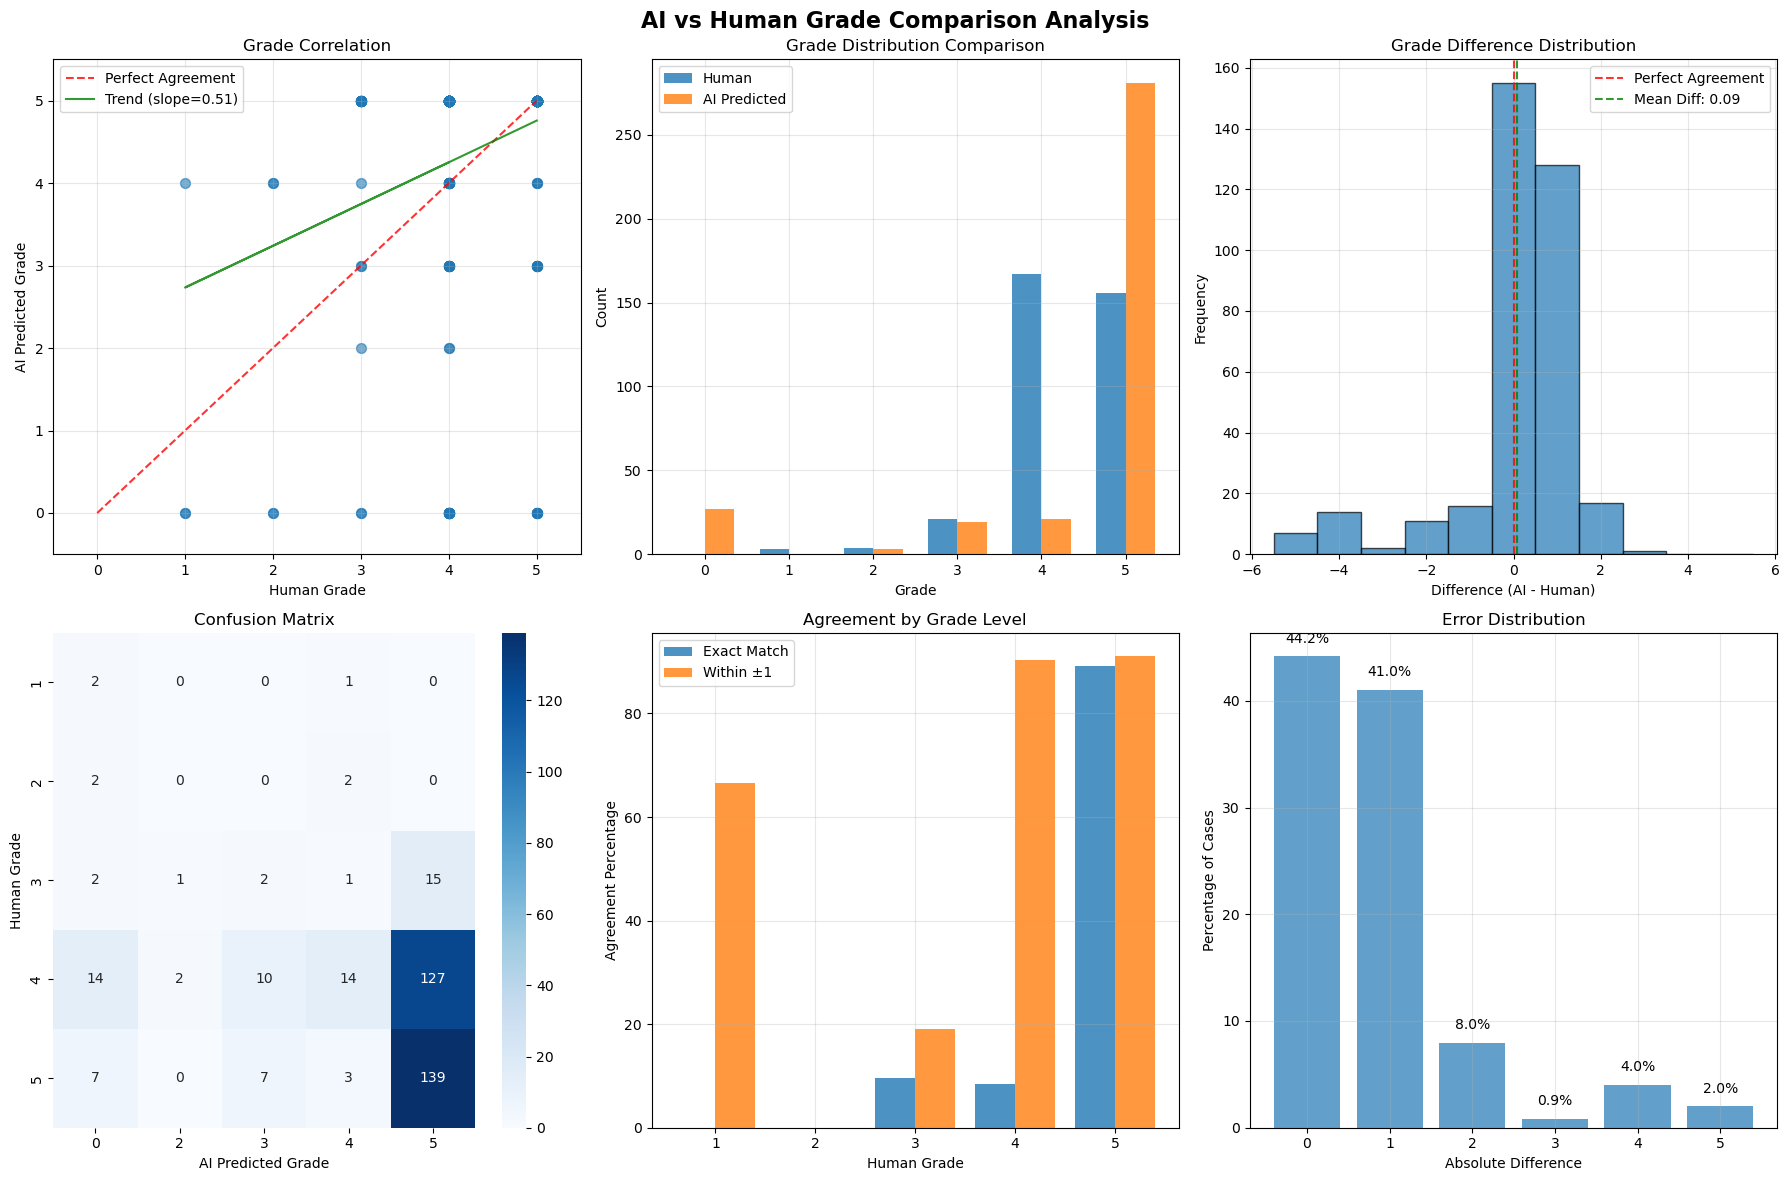


🎉 Analysis completed successfully!
📁 Generated files:
   - detailed_comparison.csv
   - grade_comparison_plots.png


In [37]:
#!/usr/bin/env python3
"""
Fixed Grade Comparison Tool
Handles the 'Failed: ' prefix and different structure in grading.json
"""

import json
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

def parse_human_grades_file(human_path: str):
    """
    Parse the human grades file which has 'Failed: ' prefix and different structure.
    
    Expected structure:
    Failed: {
      "groupId": {
        "userStories": [
          {
            "userStory": "...",
            "comment": "...", 
            "grade": X
          }
        ]
      }
    }
    """
    print(f"📖 Reading human grades from {human_path}...")
    
    with open(human_path, "r", encoding="utf-8") as f:
        content = f.read()
    
    # Remove the "Failed: " prefix
    if content.startswith("Failed: "):
        content = content[8:]  # Remove "Failed: "
        print("   ✅ Removed 'Failed: ' prefix")
    
    # Parse JSON
    try:
        raw_data = json.loads(content)
        print(f"   ✅ Successfully parsed JSON with {len(raw_data)} groups")
    except json.JSONDecodeError as e:
        print(f"   ❌ JSON parsing failed: {e}")
        return None
    
    # Convert to expected format: groupId -> list of stories
    converted_data = {}
    total_stories = 0
    
    for group_id, group_data in raw_data.items():
        if "userStories" in group_data:
            stories = []
            for story_data in group_data["userStories"]:
                # Convert to expected format
                story = {
                    "userStory": story_data.get("userStory", ""),
                    "grade": story_data.get("grade"),
                    "comment": story_data.get("comment", ""),
                    "tags": []  # Human data doesn't have tags, so empty list
                }
                stories.append(story)
                total_stories += 1
            
            converted_data[group_id] = stories
    
    print(f"   ✅ Converted {total_stories} user stories from {len(converted_data)} groups")
    return converted_data

def compare_grades(predicted_path: str, human_path: str, output_report: str = None):
    """
    Compare AI-predicted grades with human grades and generate comprehensive statistics.
    
    Args:
        predicted_path: Path to AI-graded JSON file (output from your grader)
        human_path: Path to human-graded JSON file (with 'Failed: ' prefix)
        output_report: Optional path to save detailed report
    """
    print("🔍 Loading data...")
    
    # Load predicted grades
    with open(predicted_path, "r", encoding="utf-8") as f:
        predicted_data = json.load(f)
    print(f"   ✅ Loaded AI predictions: {len(predicted_data)} groups")
    
    # Load human grades using custom parser
    human_data = parse_human_grades_file(human_path)
    if human_data is None:
        return None
    
    # Flatten and match stories
    comparisons = []
    
    for group_id, stories in predicted_data.items():
        if group_id not in human_data:
            print(f"⚠️  Group {group_id} not found in human data")
            continue
            
        human_stories = human_data[group_id]
        
        for idx, pred_story in enumerate(stories):
            if idx >= len(human_stories):
                print(f"⚠️  Story {idx} in group {group_id} not found in human data")
                continue
                
            human_story = human_stories[idx]
            
            # Verify stories match
            pred_text = pred_story.get("userStory", "").strip()
            human_text = human_story.get("userStory", "").strip()
            
            if pred_text != human_text:
                print(f"⚠️  Story mismatch in group {group_id}, index {idx}")
                print(f"    Predicted: {pred_text[:50]}...")
                print(f"    Human: {human_text[:50]}...")
                continue
            
            # Extract grades
            pred_grade = pred_story.get("grade")
            human_grade = human_story.get("grade") 
            
            if pred_grade is not None and human_grade is not None:
                comparisons.append({
                    "group_id": group_id,
                    "story_idx": idx,
                    "story": pred_text,
                    "predicted_grade": pred_grade,
                    "human_grade": human_grade,
                    "predicted_tags": pred_story.get("tags", []),
                    "human_tags": human_story.get("tags", []),
                    "difference": pred_grade - human_grade,
                    "abs_difference": abs(pred_grade - human_grade)
                })
    
    if not comparisons:
        print("❌ No matching stories found!")
        return None
    
    print(f"✅ Found {len(comparisons)} matching stories")
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(comparisons)
    
    # ============ STATISTICAL ANALYSIS ============
    print("\n" + "="*60)
    print("📊 GRADE COMPARISON STATISTICS")
    print("="*60)
    
    # Basic stats
    pred_grades = df["predicted_grade"].values
    human_grades = df["human_grade"].values
    
    print(f"📈 Overall Statistics:")
    print(f"   Total comparisons: {len(df)}")
    print(f"   Perfect matches: {sum(df['difference'] == 0)} ({sum(df['difference'] == 0)/len(df)*100:.1f}%)")
    print(f"   Within ±1 point: {sum(df['abs_difference'] <= 1)} ({sum(df['abs_difference'] <= 1)/len(df)*100:.1f}%)")
    print(f"   Mean absolute error: {df['abs_difference'].mean():.2f}")
    print(f"   Root mean square error: {np.sqrt((df['difference']**2).mean()):.2f}")
    
    # Correlation
    pearson_corr, pearson_p = pearsonr(pred_grades, human_grades)
    spearman_corr, spearman_p = spearmanr(pred_grades, human_grades)
    
    print(f"\n🔗 Correlation Analysis:")
    print(f"   Pearson correlation: {pearson_corr:.3f} (p={pearson_p:.3f})")
    print(f"   Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.3f})")
    
    # Grade distribution
    print(f"\n📊 Grade Distribution:")
    print("   Human grades:")
    human_dist = Counter(human_grades)
    for grade in sorted(human_dist.keys()):
        count = human_dist[grade]
        print(f"     Grade {grade}: {count} ({count/len(df)*100:.1f}%)")
    
    print("   Predicted grades:")
    pred_dist = Counter(pred_grades)
    for grade in sorted(pred_dist.keys()):
        count = pred_dist[grade]
        print(f"     Grade {grade}: {count} ({count/len(df)*100:.1f}%)")
    
    # Confusion Matrix
    print(f"\n🎯 Confusion Matrix (Human vs Predicted):")
    confusion = pd.crosstab(df["human_grade"], df["predicted_grade"], margins=True)
    print(confusion)
    
    # Agreement by grade level
    print(f"\n📋 Agreement by Grade Level:")
    for grade in sorted(set(human_grades)):
        subset = df[df["human_grade"] == grade]
        if len(subset) > 0:
            exact_match = sum(subset["difference"] == 0)
            within_1 = sum(subset["abs_difference"] <= 1)
            print(f"   Grade {grade}: {exact_match}/{len(subset)} exact ({exact_match/len(subset)*100:.1f}%), {within_1}/{len(subset)} within ±1 ({within_1/len(subset)*100:.1f}%)")
    
    # Bias analysis
    print(f"\n⚖️  Bias Analysis:")
    mean_diff = df["difference"].mean()
    if abs(mean_diff) < 0.1:
        bias_desc = "unbiased"
    elif mean_diff > 0:
        bias_desc = f"tends to overgrade by {mean_diff:.2f} points"
    else:
        bias_desc = f"tends to undergrade by {abs(mean_diff):.2f} points"
    print(f"   Mean difference (pred - human): {mean_diff:.2f}")
    print(f"   AI grader {bias_desc}")
    
    # Worst disagreements
    print(f"\n❌ Largest Disagreements:")
    worst = df.nlargest(5, "abs_difference")
    for _, row in worst.iterrows():
        print(f"   Story: {row['story'][:60]}...")
        print(f"   Human: {row['human_grade']}/5, AI: {row['predicted_grade']}/5 (diff: {row['difference']:+.0f})")
        print(f"   AI tags: {row['predicted_tags']}")
        print()
    
    # Save detailed report
    if output_report:
        print(f"\n💾 Saving detailed report to {output_report}")
        df.to_csv(output_report, index=False)
    
    return df

def plot_grade_comparison(df: pd.DataFrame, save_path: str = None):
    """
    Create comprehensive visualizations for grade comparison analysis.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('AI vs Human Grade Comparison Analysis', fontsize=16, fontweight='bold')
    
    # 1. Scatter plot with trend line
    axes[0,0].scatter(df['human_grade'], df['predicted_grade'], alpha=0.6, s=50)
    axes[0,0].plot([0, 5], [0, 5], 'r--', alpha=0.8, label='Perfect Agreement')
    
    # Add trend line
    z = np.polyfit(df['human_grade'], df['predicted_grade'], 1)
    p = np.poly1d(z)
    axes[0,0].plot(df['human_grade'], p(df['human_grade']), "g-", alpha=0.8, label=f'Trend (slope={z[0]:.2f})')
    
    axes[0,0].set_xlabel('Human Grade')
    axes[0,0].set_ylabel('AI Predicted Grade')
    axes[0,0].set_title('Grade Correlation')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xlim(-0.5, 5.5)
    axes[0,0].set_ylim(-0.5, 5.5)
    
    # 2. Grade distribution comparison
    grades = range(6)
    human_counts = [sum(df['human_grade'] == g) for g in grades]
    pred_counts = [sum(df['predicted_grade'] == g) for g in grades]
    
    x = np.arange(len(grades))
    width = 0.35
    
    axes[0,1].bar(x - width/2, human_counts, width, label='Human', alpha=0.8)
    axes[0,1].bar(x + width/2, pred_counts, width, label='AI Predicted', alpha=0.8)
    
    axes[0,1].set_xlabel('Grade')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_title('Grade Distribution Comparison')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(grades)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Difference histogram
    axes[0,2].hist(df['difference'], bins=11, range=(-5.5, 5.5), alpha=0.7, edgecolor='black')
    axes[0,2].axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Perfect Agreement')
    axes[0,2].axvline(x=df['difference'].mean(), color='green', linestyle='--', alpha=0.8, 
                     label=f'Mean Diff: {df["difference"].mean():.2f}')
    axes[0,2].set_xlabel('Difference (AI - Human)')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].set_title('Grade Difference Distribution')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Confusion matrix heatmap
    confusion = pd.crosstab(df['human_grade'], df['predicted_grade'])
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
    axes[1,0].set_xlabel('AI Predicted Grade')
    axes[1,0].set_ylabel('Human Grade') 
    axes[1,0].set_title('Confusion Matrix')
    
    # 5. Agreement by grade level
    grade_levels = sorted(df['human_grade'].unique())
    exact_agreements = []
    within_1_agreements = []
    
    for grade in grade_levels:
        subset = df[df['human_grade'] == grade]
        exact = sum(subset['difference'] == 0) / len(subset) * 100
        within_1 = sum(subset['abs_difference'] <= 1) / len(subset) * 100
        exact_agreements.append(exact)
        within_1_agreements.append(within_1)
    
    x = np.arange(len(grade_levels))
    axes[1,1].bar(x - 0.2, exact_agreements, 0.4, label='Exact Match', alpha=0.8)
    axes[1,1].bar(x + 0.2, within_1_agreements, 0.4, label='Within ±1', alpha=0.8)
    
    axes[1,1].set_xlabel('Human Grade')
    axes[1,1].set_ylabel('Agreement Percentage')
    axes[1,1].set_title('Agreement by Grade Level')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(grade_levels)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Error analysis by absolute difference
    abs_diffs = sorted(df['abs_difference'].unique())
    error_counts = [sum(df['abs_difference'] == diff) for diff in abs_diffs]
    error_percentages = [count/len(df)*100 for count in error_counts]
    
    axes[1,2].bar(abs_diffs, error_percentages, alpha=0.7)
    axes[1,2].set_xlabel('Absolute Difference')
    axes[1,2].set_ylabel('Percentage of Cases')
    axes[1,2].set_title('Error Distribution')
    axes[1,2].grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for i, (diff, pct) in enumerate(zip(abs_diffs, error_percentages)):
        axes[1,2].text(diff, pct + 1, f'{pct:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Visualization saved to {save_path}")
    
    plt.show()

def full_comparison_analysis(predicted_path: str, human_path: str):
    """
    Run complete comparison analysis with statistics and visualizations.
    """
    # Get comparison data
    df = compare_grades(predicted_path, human_path, "detailed_comparison.csv")
    
    if df is not None:
        # Generate visualizations  
        plot_grade_comparison(df, "grade_comparison_plots.png")
        
        return df
    else:
        print("❌ Comparison failed - check your input files")
        return None

if __name__ == "__main__":
    # Run the comparison
    print("🚀 Starting Fixed Grade Comparison Analysis...")
    
    comparison_results = full_comparison_analysis(
        predicted_path="graded_user_stories.json",
        human_path="grading.json"
    )
    
    if comparison_results is not None:
        print("\n🎉 Analysis completed successfully!")
        print("📁 Generated files:")
        print("   - detailed_comparison.csv")
        print("   - grade_comparison_plots.png")
    else:
        print("❌ Analysis failed!")


In [38]:
import json
from collections import defaultdict

# Tag penalties as defined in your system
TAG_PENALTIES = {
    "duplicate": -5,
    "irrelevant": -5,
    "vague": -2,
    "oversized": -2,
    "role-mismatch": -3,
    "ui-polish": -2,
    "typo": -1,
    "bad-structure": -3,
}

def group_user_stories_by_tags(input_file='graded_user_stories.json', output_file='stories_by_tags.json'):
    """
    Group user stories by their tags along with feedback and grades.
    """
    try:
        print(f"Reading user stories from '{input_file}'...")
        
        # Read the input JSON file
        with open(input_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Group stories by tags
        grouped_by_tags = defaultdict(list)
        
        # Process each student's stories
        for student_id, stories in data.items():
            for story in stories:
                # Get tags for this story
                story_tags = story.get('tags', [])
                
                # Create story entry with student info
                story_entry = {
                    'student_id': student_id,
                    'userStory': story.get('userStory', ''),
                    'grade': story.get('grade', 0),
                    'feedback': story.get('feedback', ''),
                    'tags': story_tags
                }
                
                # If story has no tags, put it in 'untagged' category
                if not story_tags:
                    grouped_by_tags['untagged'].append(story_entry)
                else:
                    # Add story to each tag category
                    for tag in story_tags:
                        grouped_by_tags[tag].append(story_entry)
        
        # Convert to regular dict
        result = dict(grouped_by_tags)
        
        # Save grouped data
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(result, f, indent=2, ensure_ascii=False)
        
        print(f"✅ Successfully grouped user stories by tags")
        print(f"✅ Found {len(result)} different tag categories")
        print(f"✅ Saved to '{output_file}'")
        
        return result
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

def analyze_tag_performance(grouped_data):
    """
    Analyze performance and statistics for each tag category
    """
    analysis = {}
    
    for tag, stories in grouped_data.items():
        if not stories:
            continue
            
        grades = [story['grade'] for story in stories]
        penalty = TAG_PENALTIES.get(tag, 0)
        
        # Calculate statistics
        total_stories = len(stories)
        avg_grade = sum(grades) / total_stories
        min_grade = min(grades)
        max_grade = max(grades)
        
        # Grade distribution
        grade_dist = {str(i): 0 for i in range(6)}
        for grade in grades:
            grade_dist[str(int(grade))] += 1
        
        # Student distribution
        students = list(set(story['student_id'] for story in stories))
        
        analysis[tag] = {
            'tag_penalty': penalty,
            'story_count': total_stories,
            'student_count': len(students),
            'avg_grade': round(avg_grade, 2),
            'min_grade': min_grade,
            'max_grade': max_grade,
            'grade_distribution': grade_dist,
            'students_affected': students
        }
    
    return analysis

def create_tag_report(input_file='graded_user_stories.json'):
    """
    Create a comprehensive analysis of user stories grouped by tags
    """
    print("🔍 Starting user stories tag analysis...\n")
    
    # Step 1: Group stories by tags
    grouped_data = group_user_stories_by_tags(input_file, 'stories_by_tags.json')
    
    if not grouped_data:
        print("❌ Failed to group stories by tags")
        return None
    
    print("\n📊 Analyzing tag performance...")
    
    # Step 2: Analyze tag performance
    analysis = analyze_tag_performance(grouped_data)
    
    # Step 3: Save analysis to JSON
    with open('tag_analysis.json', 'w', encoding='utf-8') as f:
        json.dump(analysis, f, indent=2, ensure_ascii=False)
    
    print("✅ Analysis saved to 'tag_analysis.json'")
    
    # Step 4: Create human-readable report
    print("📝 Creating detailed report...")
    
    with open('tag_report.txt', 'w', encoding='utf-8') as f:
        f.write("USER STORIES TAG ANALYSIS REPORT\n")
        f.write("=" * 60 + "\n\n")
        
        # Overall summary
        total_stories = sum(len(stories) for stories in grouped_data.values())
        total_students = len(set(story['student_id'] for stories in grouped_data.values() for story in stories))
        
        f.write("📋 SUMMARY:\n")
        f.write("-" * 20 + "\n")
        f.write(f"Total Stories Analyzed: {total_stories}\n")
        f.write(f"Total Students: {total_students}\n")
        f.write(f"Tag Categories Found: {len(analysis)}\n")
        f.write(f"Stories per Student (avg): {total_stories / total_students:.1f}\n\n")
        
        # Tag overview sorted by penalty severity (most severe first)
        f.write("🏷️  TAG OVERVIEW (sorted by penalty severity):\n")
        f.write("-" * 50 + "\n")
        f.write(f"{'Tag':<15} {'Penalty':<8} {'Count':<6} {'Students':<9} {'Avg Grade':<10}\n")
        f.write("-" * 50 + "\n")
        
        sorted_tags = sorted(analysis.items(), key=lambda x: x[1]['tag_penalty'])
        for tag, data in sorted_tags:
            f.write(f"{tag:<15} {data['tag_penalty']:<8} {data['story_count']:<6} "
                   f"{data['student_count']:<9} {data['avg_grade']:<10}\n")
        
        f.write("\n" + "=" * 60 + "\n\n")
        
        # Detailed breakdown for each tag
        f.write("📊 DETAILED TAG ANALYSIS:\n\n")
        
        for tag, data in sorted(analysis.items(), key=lambda x: x[1]['story_count'], reverse=True):
            f.write(f"🏷️  {tag.upper()}\n")
            f.write("-" * 30 + "\n")
            f.write(f"Penalty: {data['tag_penalty']} points\n")
            f.write(f"Stories: {data['story_count']}\n")
            f.write(f"Students affected: {data['student_count']}\n")
            f.write(f"Average grade: {data['avg_grade']}/5\n")
            f.write(f"Grade range: {data['min_grade']} - {data['max_grade']}\n")
            
            # Grade distribution
            f.write("Grade distribution: ")
            for grade, count in data['grade_distribution'].items():
                if count > 0:
                    f.write(f"{grade}★({count}) ")
            f.write("\n")
            
            # List students (first 10)
            f.write(f"Students: {', '.join(data['students_affected'][:10])}")
            if len(data['students_affected']) > 10:
                f.write(f" ... and {len(data['students_affected']) - 10} more")
            f.write("\n\n")
            
            f.write("-" * 60 + "\n\n")
    
    print("✅ Detailed report saved to 'tag_report.txt'")
    
    # Step 5: Print summary to console
    print("\n🎯 KEY INSIGHTS:")
    print("-" * 40)
    
    # Most problematic tag (most severe penalty)
    if analysis:
        worst_tag = min(analysis.items(), key=lambda x: x[1]['tag_penalty'])
        print(f"Most severe issue: {worst_tag[0]} ({worst_tag[1]['story_count']} stories, {worst_tag[1]['tag_penalty']} pts each)")
        
        # Most common issue
        common_tag = max(analysis.items(), key=lambda x: x[1]['story_count'])
        print(f"Most common issue: {common_tag[0]} ({common_tag[1]['story_count']} stories)")
        
        # Show tag breakdown
        print(f"\nTag breakdown:")
        for tag, data in sorted(analysis.items(), key=lambda x: x[1]['story_count'], reverse=True):
            print(f"  • {tag}: {data['story_count']} stories ({data['student_count']} students)")
    
    print(f"\n📁 Files created:")
    print(f"   • stories_by_tags.json - Stories grouped by tags")
    print(f"   • tag_analysis.json - Detailed statistics")
    print(f"   • tag_report.txt - Human-readable report")
    
    return analysis

def print_tag_definitions():
    """
    Print what each tag means and its penalty
    """
    print("\n🏷️  TAG DEFINITIONS AND PENALTIES:")
    print("=" * 45)
    
    tag_descriptions = {
        "duplicate": "Story is a duplicate of another story",
        "irrelevant": "Story is outside the scope of ToDo app",
        "vague": "Story lacks specific details or clarity",
        "oversized": "Story is too complex, should be broken down",
        "role-mismatch": "Wrong user role specified for the context",
        "ui-polish": "Cosmetic feature, not core functionality",
        "typo": "Contains spelling or grammatical errors",
        "bad-structure": "Doesn't follow proper user story format"
    }
    
    for tag, penalty in sorted(TAG_PENALTIES.items(), key=lambda x: x[1]):
        desc = tag_descriptions.get(tag, "No description available")
        print(f"  {tag:<15} ({penalty:>2} pts): {desc}")
    
    print(f"  {'untagged':<15} ({0:>2} pts): No quality issues identified")

# Main execution
if __name__ == "__main__":
    import os
    
    print_tag_definitions()
    print("\n" + "="*60)
    
    # Check if the input file exists
    try:
        with open('graded_user_stories.json', 'r') as f:
            pass
        print("✅ Found 'graded_user_stories.json' file")
    except FileNotFoundError:
        print("❌ Error: 'graded_user_stories.json' file not found!")
        print("   Please make sure the file exists in the current directory.")
        print(f"   Current directory: {os.getcwd()}")
        print(f"   Files in directory: {os.listdir('.')}")
        exit()
    
    # Run the analysis
    analysis = create_tag_report()
    
    if analysis:
        print(f"\n✅ Analysis completed successfully!")
        
        # Show file locations and verify they exist
        print(f"\n📁 File verification:")
        files_to_check = ['stories_by_tags.json', 'tag_analysis.json', 'tag_report.txt']
        for filename in files_to_check:
            if os.path.exists(filename):
                size = os.path.getsize(filename)
                print(f"   ✅ {filename} ({size:,} bytes)")
            else:
                print(f"   ❌ {filename} - NOT FOUND")
        
        print(f"\n📂 Current working directory: {os.getcwd()}")
        
        # In Jupyter, also display a sample of the data
        print(f"\n📋 SAMPLE OF GROUPED DATA:")
        print("-" * 40)
        
        # Read and show sample from stories_by_tags.json
        try:
            with open('stories_by_tags.json', 'r') as f:
                grouped_data = json.load(f)
            
            # Show first few entries from each tag
            for tag, stories in list(grouped_data.items())[:3]:
                print(f"\n🏷️ {tag.upper()}: {len(stories)} stories")
                for i, story in enumerate(stories[:2]):
                    print(f"   {i+1}. Student {story['student_id']} (Grade: {story['grade']})")
                    story_preview = story['userStory'][:60] + "..." if len(story['userStory']) > 60 else story['userStory']
                    print(f"      \"{story_preview}\"")
                if len(stories) > 2:
                    print(f"      ... and {len(stories) - 2} more stories")
        except:
            print("Could not read sample data")
            
    else:
        print(f"\n❌ Analysis failed!")

# For Jupyter notebook users - add these helper functions
def show_files_in_current_directory():
    """Show all files in the current directory"""
    import os
    print("📁 Files in current directory:")
    files = os.listdir('.')
    for file in sorted(files):
        if os.path.isfile(file):
            size = os.path.getsize(file)
            print(f"   📄 {file} ({size:,} bytes)")
        else:
            print(f"   📁 {file}/")

def display_tag_analysis_summary():
    """Display a summary of the tag analysis (for Jupyter)"""
    try:
        with open('tag_analysis.json', 'r') as f:
            analysis = json.load(f)
        
        print("📊 TAG ANALYSIS SUMMARY:")
        print("=" * 50)
        
        # Create a simple table
        print(f"{'Tag':<15} {'Stories':<8} {'Students':<9} {'Avg Grade':<10} {'Penalty':<8}")
        print("-" * 50)
        
        for tag, data in sorted(analysis.items(), key=lambda x: x[1]['story_count'], reverse=True):
            print(f"{tag:<15} {data['story_count']:<8} {data['student_count']:<9} "
                  f"{data['avg_grade']:<10} {data['tag_penalty']:<8}")
                  
        return analysis
    except FileNotFoundError:
        print("❌ tag_analysis.json not found. Run create_tag_report() first.")
        return None

def show_stories_for_tag(tag_name):
    """Show all stories for a specific tag"""
    try:
        with open('stories_by_tags.json', 'r') as f:
            grouped_data = json.load(f)
        
        if tag_name not in grouped_data:
            print(f"❌ Tag '{tag_name}' not found.")
            print(f"Available tags: {', '.join(grouped_data.keys())}")
            return
        
        stories = grouped_data[tag_name]
        print(f"🏷️ {tag_name.upper()}: {len(stories)} stories")
        print("=" * 50)
        
        for i, story in enumerate(stories, 1):
            print(f"\n{i}. Student: {story['student_id']} | Grade: {story['grade']}")
            print(f"   Story: \"{story['userStory']}\"")
            print(f"   Feedback: {story['feedback']}")
            
    except FileNotFoundError:
        print("❌ stories_by_tags.json not found. Run create_tag_report() first.")

# Add these functions for easy access in Jupyter
print("\n💡 Jupyter Helper Functions Available:")
print("   • show_files_in_current_directory() - List all files")
print("   • display_tag_analysis_summary() - Show analysis table") 
print("   • show_stories_for_tag('tag_name') - Show stories for specific tag")
print("   • create_tag_report() - Run the full analysis")


🏷️  TAG DEFINITIONS AND PENALTIES:
  duplicate       (-5 pts): Story is a duplicate of another story
  irrelevant      (-5 pts): Story is outside the scope of ToDo app
  role-mismatch   (-3 pts): Wrong user role specified for the context
  bad-structure   (-3 pts): Doesn't follow proper user story format
  vague           (-2 pts): Story lacks specific details or clarity
  oversized       (-2 pts): Story is too complex, should be broken down
  ui-polish       (-2 pts): Cosmetic feature, not core functionality
  typo            (-1 pts): Contains spelling or grammatical errors
  untagged        ( 0 pts): No quality issues identified

✅ Found 'graded_user_stories.json' file
🔍 Starting user stories tag analysis...

Reading user stories from 'graded_user_stories.json'...
✅ Successfully grouped user stories by tags
✅ Found 9 different tag categories
✅ Saved to 'stories_by_tags.json'

📊 Analyzing tag performance...
✅ Analysis saved to 'tag_analysis.json'
📝 Creating detailed report...
✅ Deta

In [2]:
import json
from collections import Counter

def analyze_grades(input_file='graded_user_stories.json'):
    """
    Analyze grades from user stories - show average and distribution
    """
    try:
        # Read the graded user stories
        with open(input_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Collect all grades
        all_grades = []
        grade_counter = Counter()
        
        total_stories = 0
        total_students = len(data)
        
        # Extract grades from all stories
        for student_id, stories in data.items():
            for story in stories:
                grade = story.get('grade', 0)
                all_grades.append(grade)
                grade_counter[int(grade)] += 1
                total_stories += 1
        
        # Calculate average
        if all_grades:
            average_grade = sum(all_grades) / len(all_grades)
        else:
            average_grade = 0
        
        # Print results
        print("📊 GRADE ANALYSIS REPORT")
        print("=" * 40)
        print(f"Total Stories: {total_stories}")
        print(f"Total Students: {total_students}")
        print(f"Average Grade: {average_grade:.2f}/5")
        print()
        
        print("📈 GRADE DISTRIBUTION:")
        print("-" * 30)
        
        # Show distribution for grades 0-5
        for grade in range(6):
            count = grade_counter.get(grade, 0)
            percentage = (count / total_stories * 100) if total_stories > 0 else 0
            stars = "★" * grade if grade > 0 else "☆"
            bar = "█" * int(percentage // 2)  # Visual bar
            
            print(f"Grade {grade} {stars:<5}: {count:4d} stories ({percentage:5.1f}%) {bar}")
        
        print()
        print("📋 SUMMARY STATISTICS:")
        print("-" * 25)
        print(f"Highest Grade: {max(all_grades) if all_grades else 0}")
        print(f"Lowest Grade: {min(all_grades) if all_grades else 0}")
        print(f"Most Common Grade: {grade_counter.most_common(1)[0][0] if grade_counter else 'N/A'}")
        
        # Calculate some interesting stats
        perfect_stories = grade_counter.get(5, 0)
        failed_stories = grade_counter.get(0, 0)
        passed_stories = sum(grade_counter.get(i, 0) for i in range(3, 6))  # Grades 3, 4, 5
        
        print(f"Perfect Stories (5★): {perfect_stories} ({perfect_stories/total_stories*100:.1f}%)")
        print(f"Failed Stories (0★): {failed_stories} ({failed_stories/total_stories*100:.1f}%)")
        print(f"Passing Stories (3★+): {passed_stories} ({passed_stories/total_stories*100:.1f}%)")
        
        return {
            'total_stories': total_stories,
            'total_students': total_students,
            'average_grade': average_grade,
            'grade_distribution': dict(grade_counter),
            'all_grades': all_grades
        }
        
    except FileNotFoundError:
        print(f"❌ Error: File '{input_file}' not found!")
        return None
    except Exception as e:
        print(f"❌ Error analyzing grades: {str(e)}")
        return None

def analyze_grades_by_tag(input_file='graded_user_stories.json'):
    """
    Analyze grades broken down by tag categories
    """
    try:
        # Read the graded user stories
        with open(input_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Group grades by tags
        tag_grades = {}
        
        for student_id, stories in data.items():
            for story in stories:
                grade = story.get('grade', 0)
                tags = story.get('tags', [])
                
                # If no tags, use 'untagged'
                if not tags:
                    tags = ['untagged']
                
                for tag in tags:
                    if tag not in tag_grades:
                        tag_grades[tag] = []
                    tag_grades[tag].append(grade)
        
        print("\n📊 GRADE ANALYSIS BY TAG")
        print("=" * 60)
        print(f"{'Tag':<15} {'Count':<6} {'Avg':<6} {'0★':<4} {'1★':<4} {'2★':<4} {'3★':<4} {'4★':<4} {'5★':<4}")
        print("-" * 60)
        
        # Sort by average grade (lowest first to show problem areas)
        for tag, grades in sorted(tag_grades.items(), key=lambda x: sum(x[1])/len(x[1])):
            count = len(grades)
            avg = sum(grades) / count
            
            # Count each grade
            grade_counts = Counter(int(g) for g in grades)
            
            print(f"{tag:<15} {count:<6} {avg:<6.2f} ", end="")
            for grade in range(6):
                print(f"{grade_counts.get(grade, 0):<4}", end="")
            print()
        
        return tag_grades
        
    except Exception as e:
        print(f"❌ Error analyzing grades by tag: {str(e)}")
        return None

def analyze_student_performance(input_file='graded_user_stories.json', show_top=10):
    """
    Analyze individual student performance
    """
    try:
        # Read the graded user stories
        with open(input_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        student_stats = {}
        
        for student_id, stories in data.items():
            grades = [story.get('grade', 0) for story in stories]
            
            student_stats[student_id] = {
                'total_stories': len(stories),
                'average_grade': sum(grades) / len(grades) if grades else 0,
                'grades': grades,
                'grade_distribution': Counter(int(g) for g in grades)
            }
        
        print(f"\n👥 STUDENT PERFORMANCE ANALYSIS")
        print("=" * 50)
        
        # Top performers
        top_students = sorted(student_stats.items(), key=lambda x: x[1]['average_grade'], reverse=True)
        
        print(f"\n🏆 TOP {show_top} PERFORMERS:")
        print("-" * 35)
        print(f"{'Student':<10} {'Stories':<8} {'Avg Grade':<10}")
        print("-" * 35)
        
        for student_id, stats in top_students[:show_top]:
            print(f"{student_id:<10} {stats['total_stories']:<8} {stats['average_grade']:<10.2f}")
        
        # Bottom performers
        print(f"\n📉 BOTTOM {show_top} PERFORMERS:")
        print("-" * 35)
        print(f"{'Student':<10} {'Stories':<8} {'Avg Grade':<10}")
        print("-" * 35)
        
        for student_id, stats in top_students[-show_top:]:
            print(f"{student_id:<10} {stats['total_stories']:<8} {stats['average_grade']:<10.2f}")
        
        return student_stats
        
    except Exception as e:
        print(f"❌ Error analyzing student performance: {str(e)}")
        return None

def quick_grade_stats(input_file='graded_user_stories.json'):
    """
    Quick one-liner grade statistics
    """
    try:
        with open(input_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        all_grades = []
        for stories in data.values():
            for story in stories:
                all_grades.append(story.get('grade', 0))
        
        if not all_grades:
            print("No grades found!")
            return
        
        avg = sum(all_grades) / len(all_grades)
        grade_counts = Counter(int(g) for g in all_grades)
        
        print(f"📊 Quick Stats: {len(all_grades)} stories, Avg: {avg:.2f}/5")
        print(f"Distribution: ", end="")
        for grade in range(6):
            count = grade_counts.get(grade, 0)
            print(f"{grade}★:{count} ", end="")
        print()
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")

# Run all analyses
if __name__ == "__main__":
    print("🎯 COMPREHENSIVE GRADE ANALYSIS")
    print("=" * 50)
    
    # Main grade analysis
    grade_data = analyze_grades()
    
    if grade_data:
        # Grade analysis by tag
        analyze_grades_by_tag()
        
        # Student performance analysis
        analyze_student_performance()

# Helper functions for Jupyter
print("\n💡 Available Functions:")
print("   • analyze_grades() - Main grade analysis with distribution")
print("   • analyze_grades_by_tag() - Grade breakdown by tag categories") 
print("   • analyze_student_performance() - Individual student stats")
print("   • quick_grade_stats() - One-liner summary")

🎯 COMPREHENSIVE GRADE ANALYSIS
📊 GRADE ANALYSIS REPORT
Total Stories: 351
Total Students: 174
Average Grade: 3.69/5

📈 GRADE DISTRIBUTION:
------------------------------
Grade 0 ☆    :   59 stories ( 16.8%) ████████
Grade 1 ★    :    2 stories (  0.6%) 
Grade 2 ★★   :   13 stories (  3.7%) █
Grade 3 ★★★  :   51 stories ( 14.5%) ███████
Grade 4 ★★★★ :   16 stories (  4.6%) ██
Grade 5 ★★★★★:  210 stories ( 59.8%) █████████████████████████████

📋 SUMMARY STATISTICS:
-------------------------
Highest Grade: 5
Lowest Grade: 0
Most Common Grade: 5
Perfect Stories (5★): 210 (59.8%)
Failed Stories (0★): 59 (16.8%)
Passing Stories (3★+): 277 (78.9%)

📊 GRADE ANALYSIS BY TAG
Tag             Count  Avg    0★   1★   2★   3★   4★   5★  
------------------------------------------------------------
irrelevant      9      0.00   9   0   0   0   0   0   
duplicate       46     0.00   46  0   0   0   0   0   
bad-structure   2      0.00   2   0   0   0   0   0   
role-mismatch   14     1.64   2   1   11